In [ ]:
#DataSet for classification models: https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000
#DataSet for detection model (YOLO): we prepared it using the DataSet (after extracting the images from the folders structure) in https://app.roboflow.com/

In [1]:
from PIL import Image
import tempfile
import os
import shutil
import torch
import torchvision.transforms as transforms
from ultralytics import YOLO
from timm import create_model
import numpy as np
import pandas as pd
import torchvision.models as Tmodels
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTModel
import cv2
from PIL import Image as PILImage
from rembg import remove
import torchvision.utils as vutils
from sklearn.model_selection import KFold

#Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Paths
metadata_path = "data/pokemon-dataset-1000/metadata.csv"
train_dir = "data/pokemon-dataset-1000/train"
test_dir = "data/pokemon-dataset-1000/test"

#Load metadata
metadata = pd.read_csv(metadata_path)
metadata.head()
print("Metadata columns:", metadata.columns)

/home/omerd/anaconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
Metadata columns: Index(['label', 'image_path', 'hp', 'attack', 'defense', 'special-attack',
       'special-defense', 'speed'],
      dtype='object')


In [2]:
#Train yolo model first due to ultralytics training automaticly cleaning vram after trainig. training is done with transferlerning on weights from https://github.com/vovod/yolov8-pokemon-object-detection
modelyolo= YOLO("yolov8n.yaml").load("vovodbest.pt")
#modelyolo= YOLO("yolov8n.yaml").load("yolov8n.pt")
results = modelyolo.train( data="data.yaml", epochs=50, imgsz=128, device=0, batch=1000, mask_ratio=4, plots=True, name='vovodtransfer',patience=0, close_mosaic=4, workers=4, freeze=17,multi_scale=True)

Transferred 319/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.73 🚀 Python-3.12.7 torch-2.7.0.dev20250207+cu128 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=50, time=None, patience=0, batch=1000, imgsz=128, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=vovodtransfer20, exist_ok=False, pretrained=vovodbest.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=4, resume=False, amp=True, fraction=1.0, profile=False, freeze=17, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

train: Scanning /home/omerd/dlfinalprojmerged/train/labels.cache... 7018 images, 0 backgrounds, 0 corrupt: 100%|████

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/omerd/dlfinalprojmerged/valid/labels.cache... 1008 images, 0 backgrounds, 0 corrupt: 100%|██████


Plotting labels to runs/detect/vovodtransfer20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0078125), 63 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 4 dataloader workers
Logging results to runs/detect/vovodtransfer20
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.13G      1.771      3.264      1.615         50        128: 100%|██████████| 8/8 [00:09<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008     0.0169      0.992       0.87      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       5.7G      1.608      3.093       1.55         50         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.943      0.909       0.94      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.22G      1.569      2.365      1.445         50         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008       0.97      0.752      0.956       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.62G      1.452      1.872      1.385         34        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.921      0.928      0.963      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.93G      1.345       1.54      1.321         44         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.914      0.948      0.975      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.74G      1.372      1.556      1.281         45        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.878      0.916      0.952      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.84G      1.346      1.492      1.247         40         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.784       0.74      0.828       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.05G      1.285      1.386      1.215         54         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.824      0.855      0.909      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.69G      1.175      1.154      1.186         41         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.923      0.903      0.967      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.12G        1.1      1.022      1.157         45        160: 100%|██████████| 8/8 [00:04<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.894      0.811      0.922      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.72G      1.193      1.138      1.173         41         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008       0.79      0.863      0.861      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.68G      1.285       1.22       1.18         48         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.859      0.928      0.953      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.22G      1.186      1.172       1.17         49         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.907      0.893      0.952      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.98G      1.089      0.962      1.124         41         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.917       0.85      0.924      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.73G      1.137      1.027      1.134         47         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.932      0.945       0.97       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.02G      1.191      1.057      1.135         52        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.924      0.958      0.971      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.61G      1.216      1.122      1.157         43        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.917      0.938      0.963      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.95G      1.275      1.158      1.159         41        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.742       0.73      0.795      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.33G      1.255       1.11      1.154         49         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.808       0.75      0.862      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.49G       1.18      1.029       1.15         43        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.943      0.931       0.98      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.09G      1.181     0.9987      1.132         51        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.915      0.923      0.971      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.61G      1.141     0.9525      1.138         45        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.782      0.924      0.917      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.18G      1.088     0.8879      1.121         44         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.935      0.934      0.977      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.92G      1.056     0.8619      1.118         46        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.928      0.975      0.984       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.69G       1.01     0.8281      1.105         44        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.966      0.972       0.99      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.71G      1.067      0.843      1.104         41        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.968      0.973       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         4G      1.013     0.7977      1.093         45        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.956      0.974       0.99      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       5.4G     0.9602     0.7495      1.083         53        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008       0.97      0.978      0.993      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.83G      1.088     0.8393      1.098         42         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.963      0.969      0.991      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.71G     0.9708     0.7517      1.091         53        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.978       0.97      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.5G      1.051     0.8067      1.091         44        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.973      0.973      0.992      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.63G      1.021     0.7824      1.086         47        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.971      0.973      0.991      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.78G      1.074     0.8377      1.091         53         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.961      0.975      0.992      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.98G       1.07     0.7954      1.092         49        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.957      0.961      0.988      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.81G      1.024     0.7885      1.086         44        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.967      0.967      0.991      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.66G       1.05     0.7846      1.088         49        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.969      0.972      0.991      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.1G      1.025      0.751       1.08         45        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008       0.98      0.986      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.74G      1.046     0.7778      1.079         47        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008       0.98      0.977      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.94G     0.9355     0.6988       1.07         55        192: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.985      0.984      0.994      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.57G      1.002     0.7215      1.075         37         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.988      0.985      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.02G      1.009     0.7307      1.075         46         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.981      0.987      0.993      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.23G      0.989      0.712       1.07         44        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.981      0.987      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.68G      1.003     0.7357      1.076         45        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.983      0.988      0.994      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.33G     0.9474     0.6974      1.061         47        160: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.984      0.984      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.12G     0.9885     0.7261       1.07         39         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.978       0.99      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.03G     0.9791     0.7147      1.072         45         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.988      0.986      0.994      0.808


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.59G     0.8171     0.6972     0.9832         18         96: 100%|██████████| 8/8 [00:05<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.992      0.996      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.13G     0.6831     0.5358     0.9647         18        128: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.993      0.995      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.69G     0.6814     0.4918     0.9436         18         96: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.996      0.996      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.72G     0.7319     0.5073     0.9451         18         64: 100%|██████████| 8/8 [00:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0

                   all       1008       1008      0.996      0.996      0.995      0.823



50 epochs completed in 0.106 hours.
Optimizer stripped from runs/detect/vovodtransfer20/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/vovodtransfer20/weights/best.pt, 6.2MB

Validating runs/detect/vovodtransfer20/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.12.7 torch-2.7.0.dev20250207+cu128 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:0


                   all       1008       1008      0.995      0.996      0.995      0.821
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/vovodtransfer20


Yolo Lable Data:

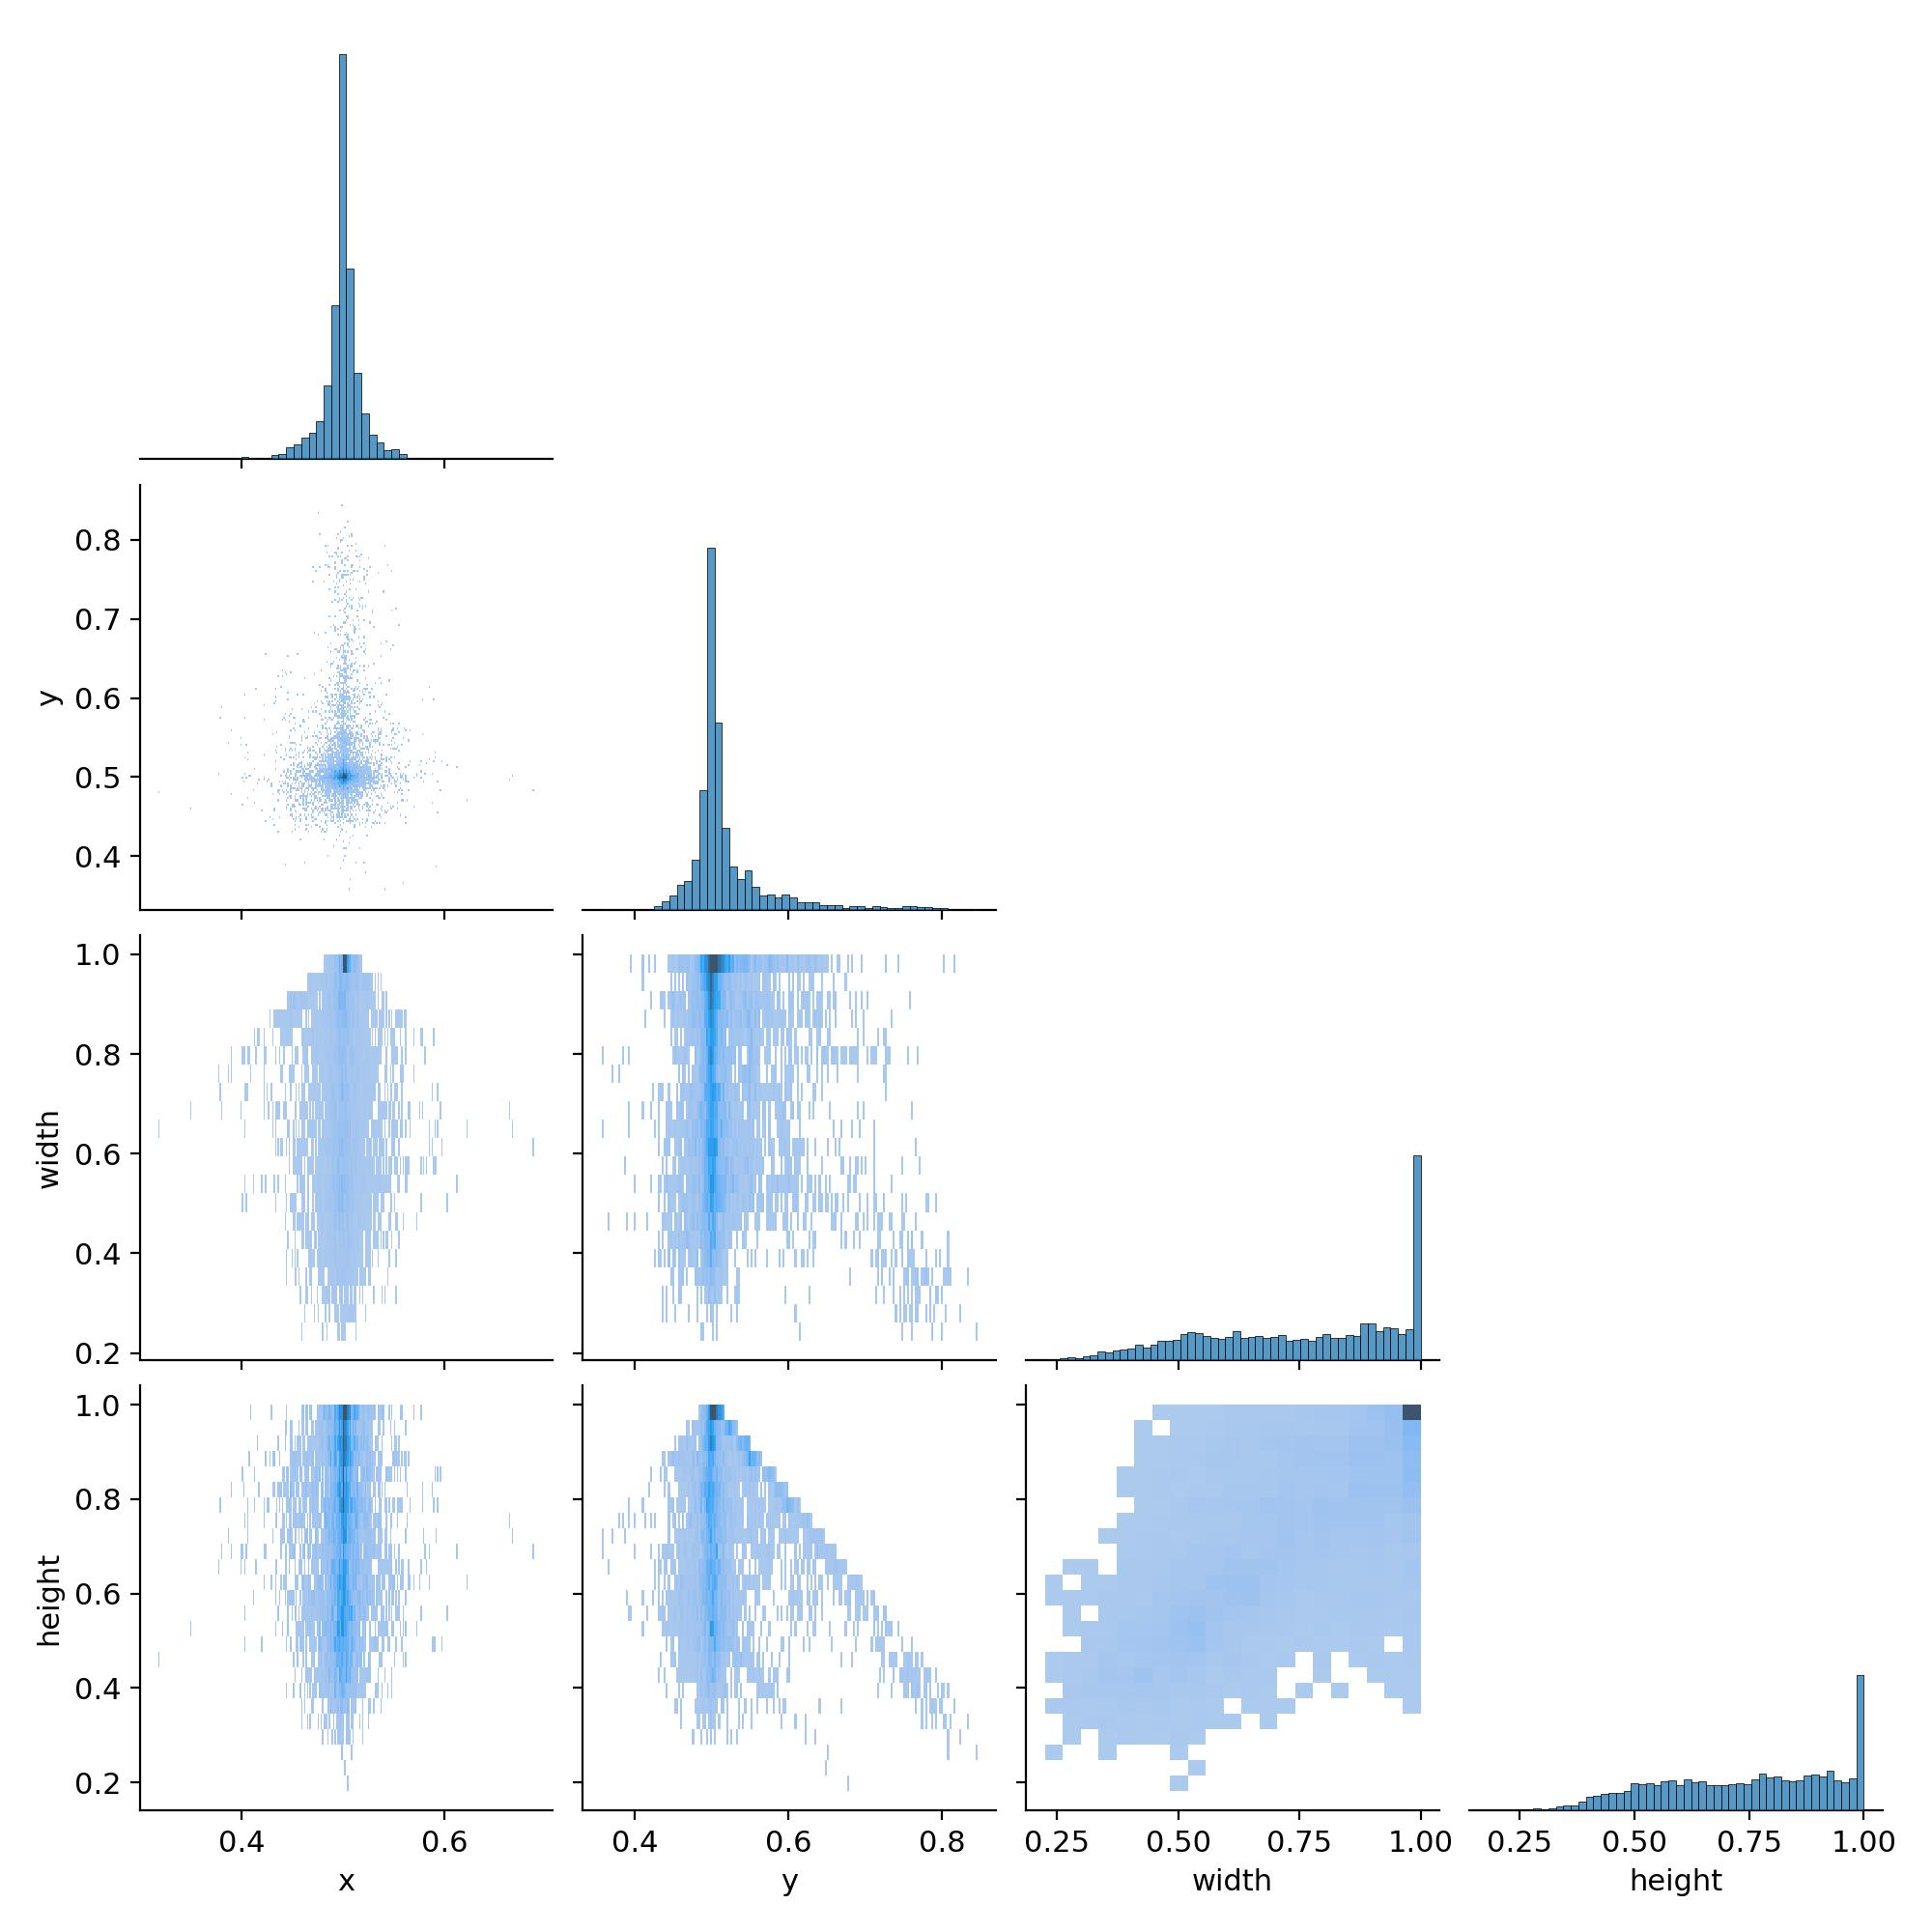


Train Batches(mosiac is closed on last 4 epoches):


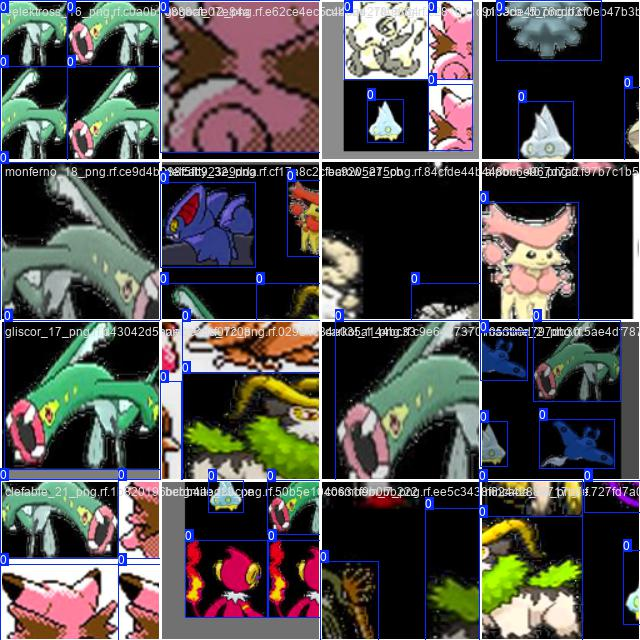


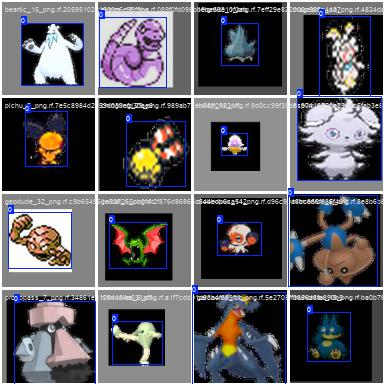

Validation Batches:

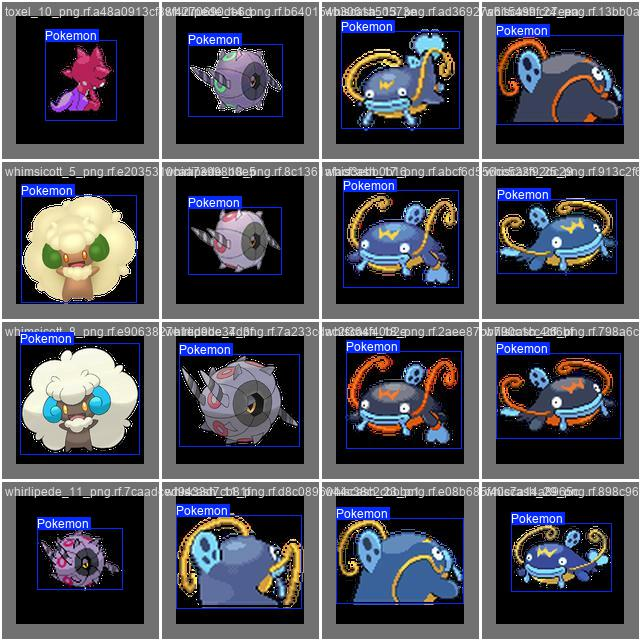
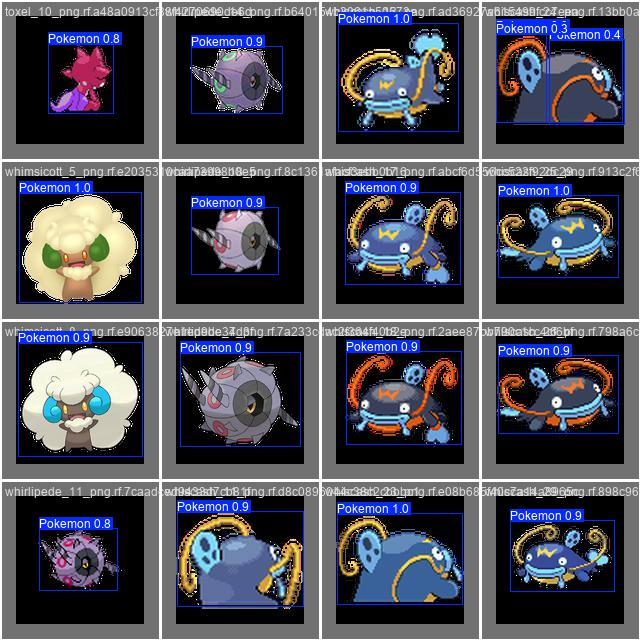


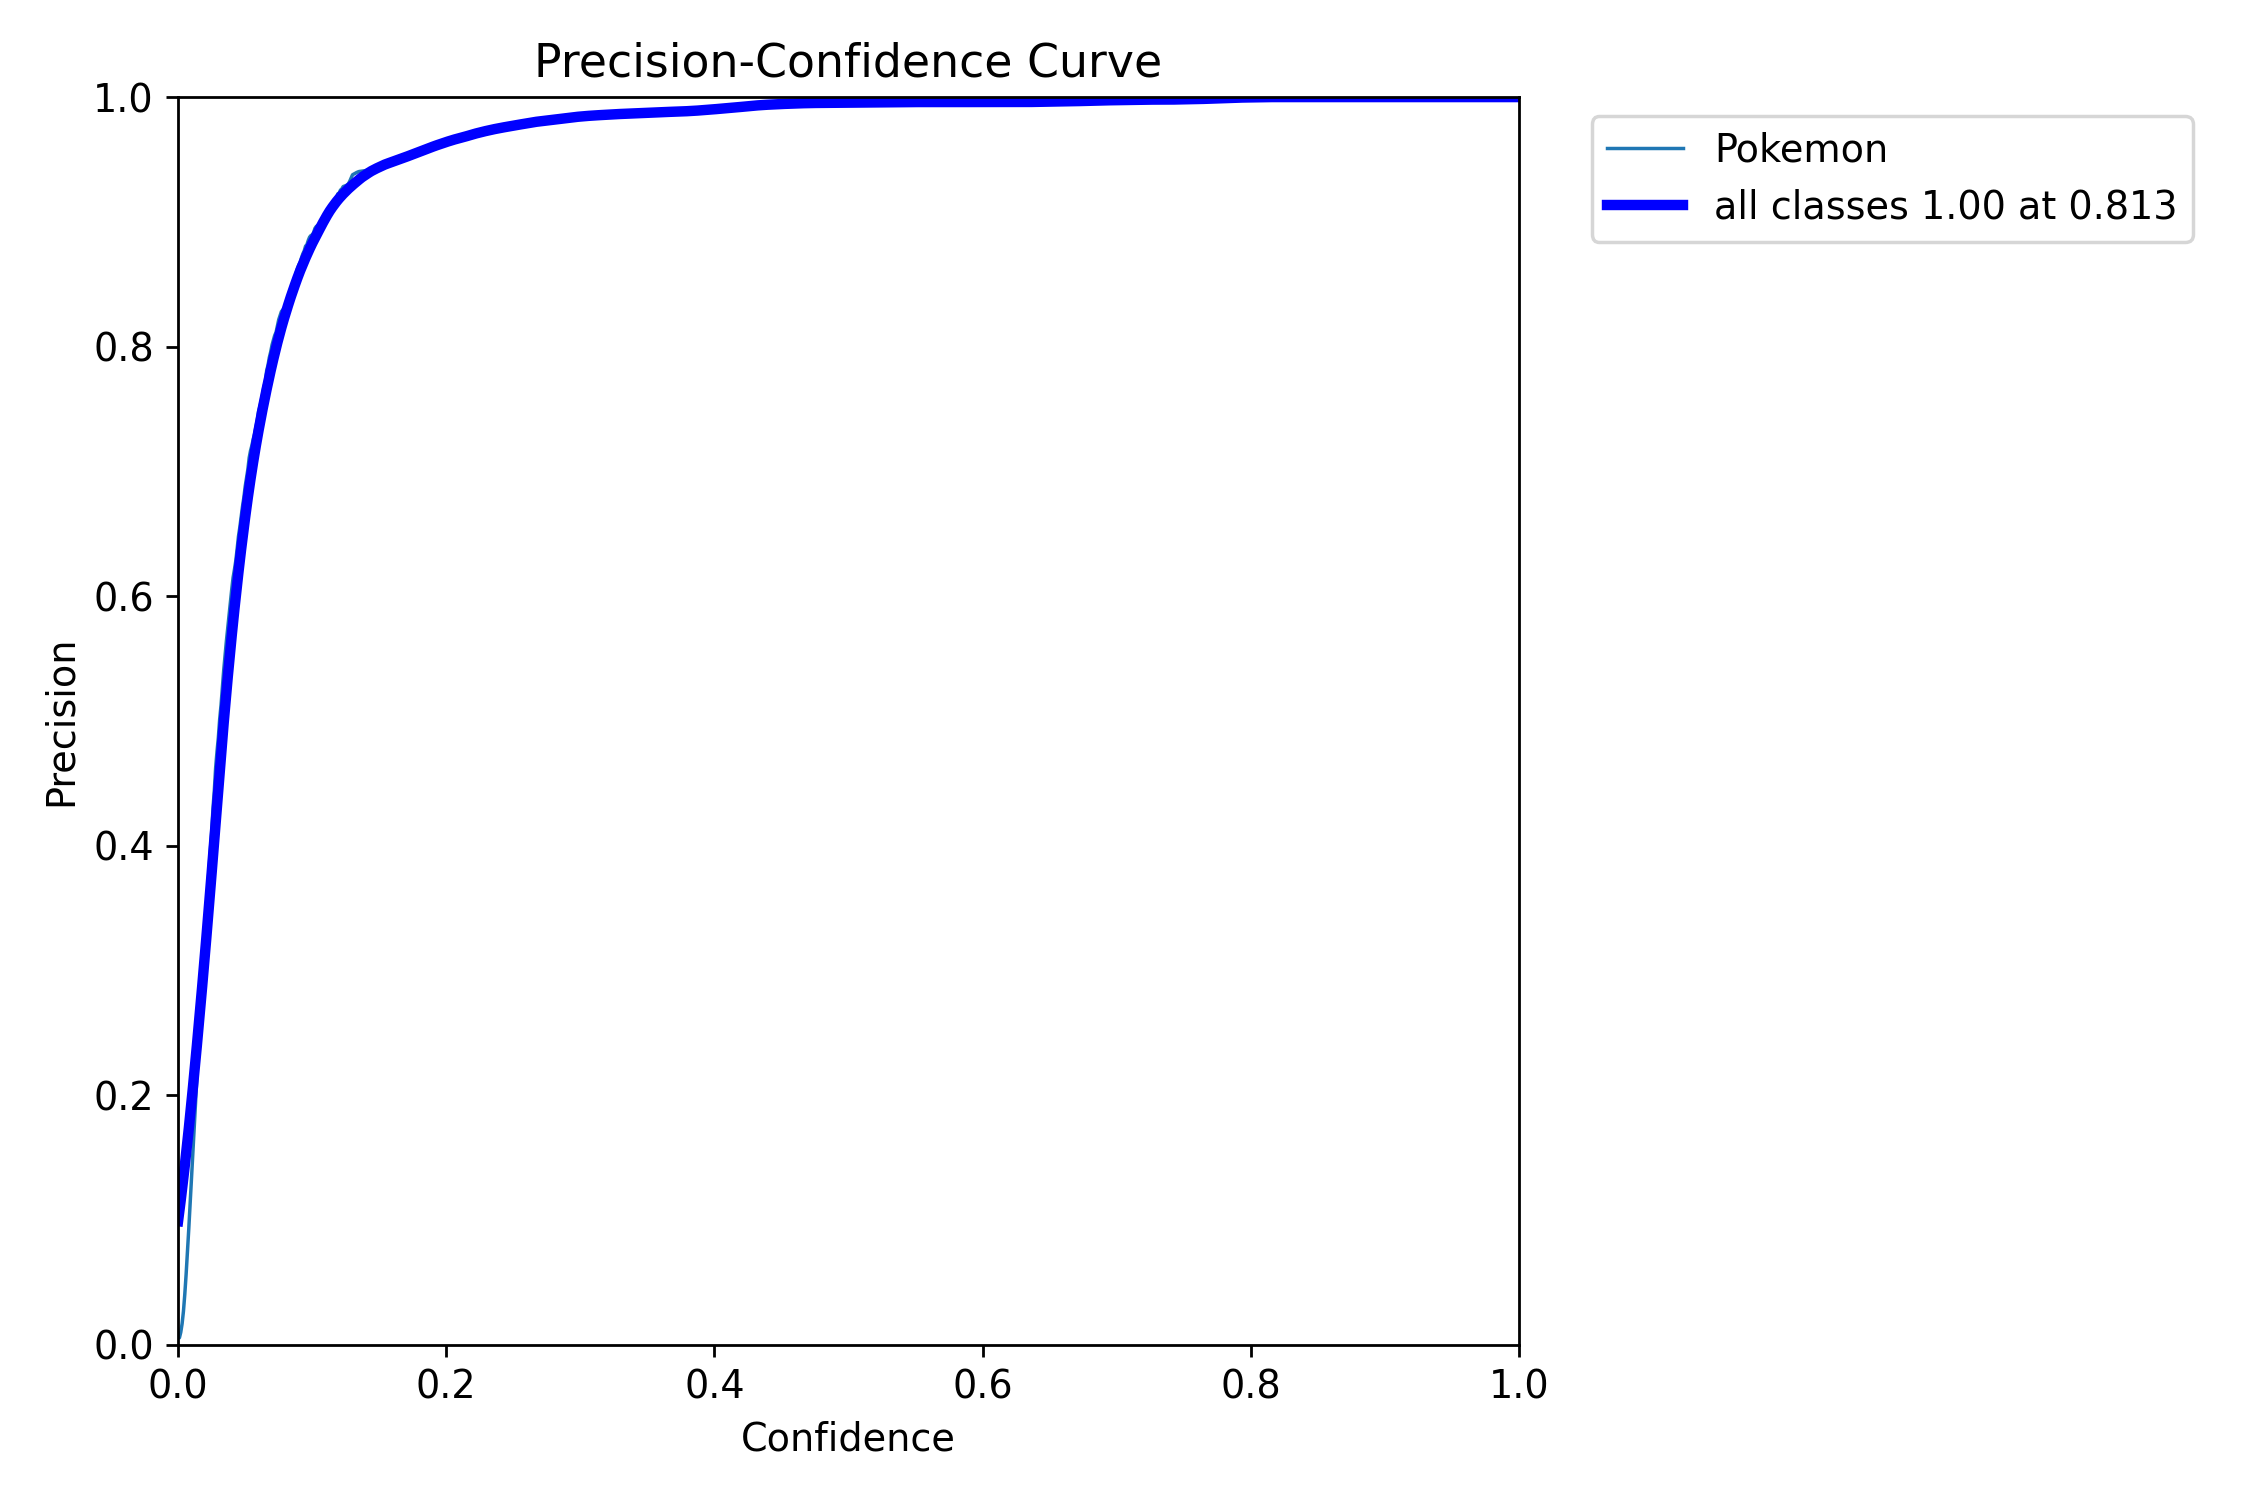
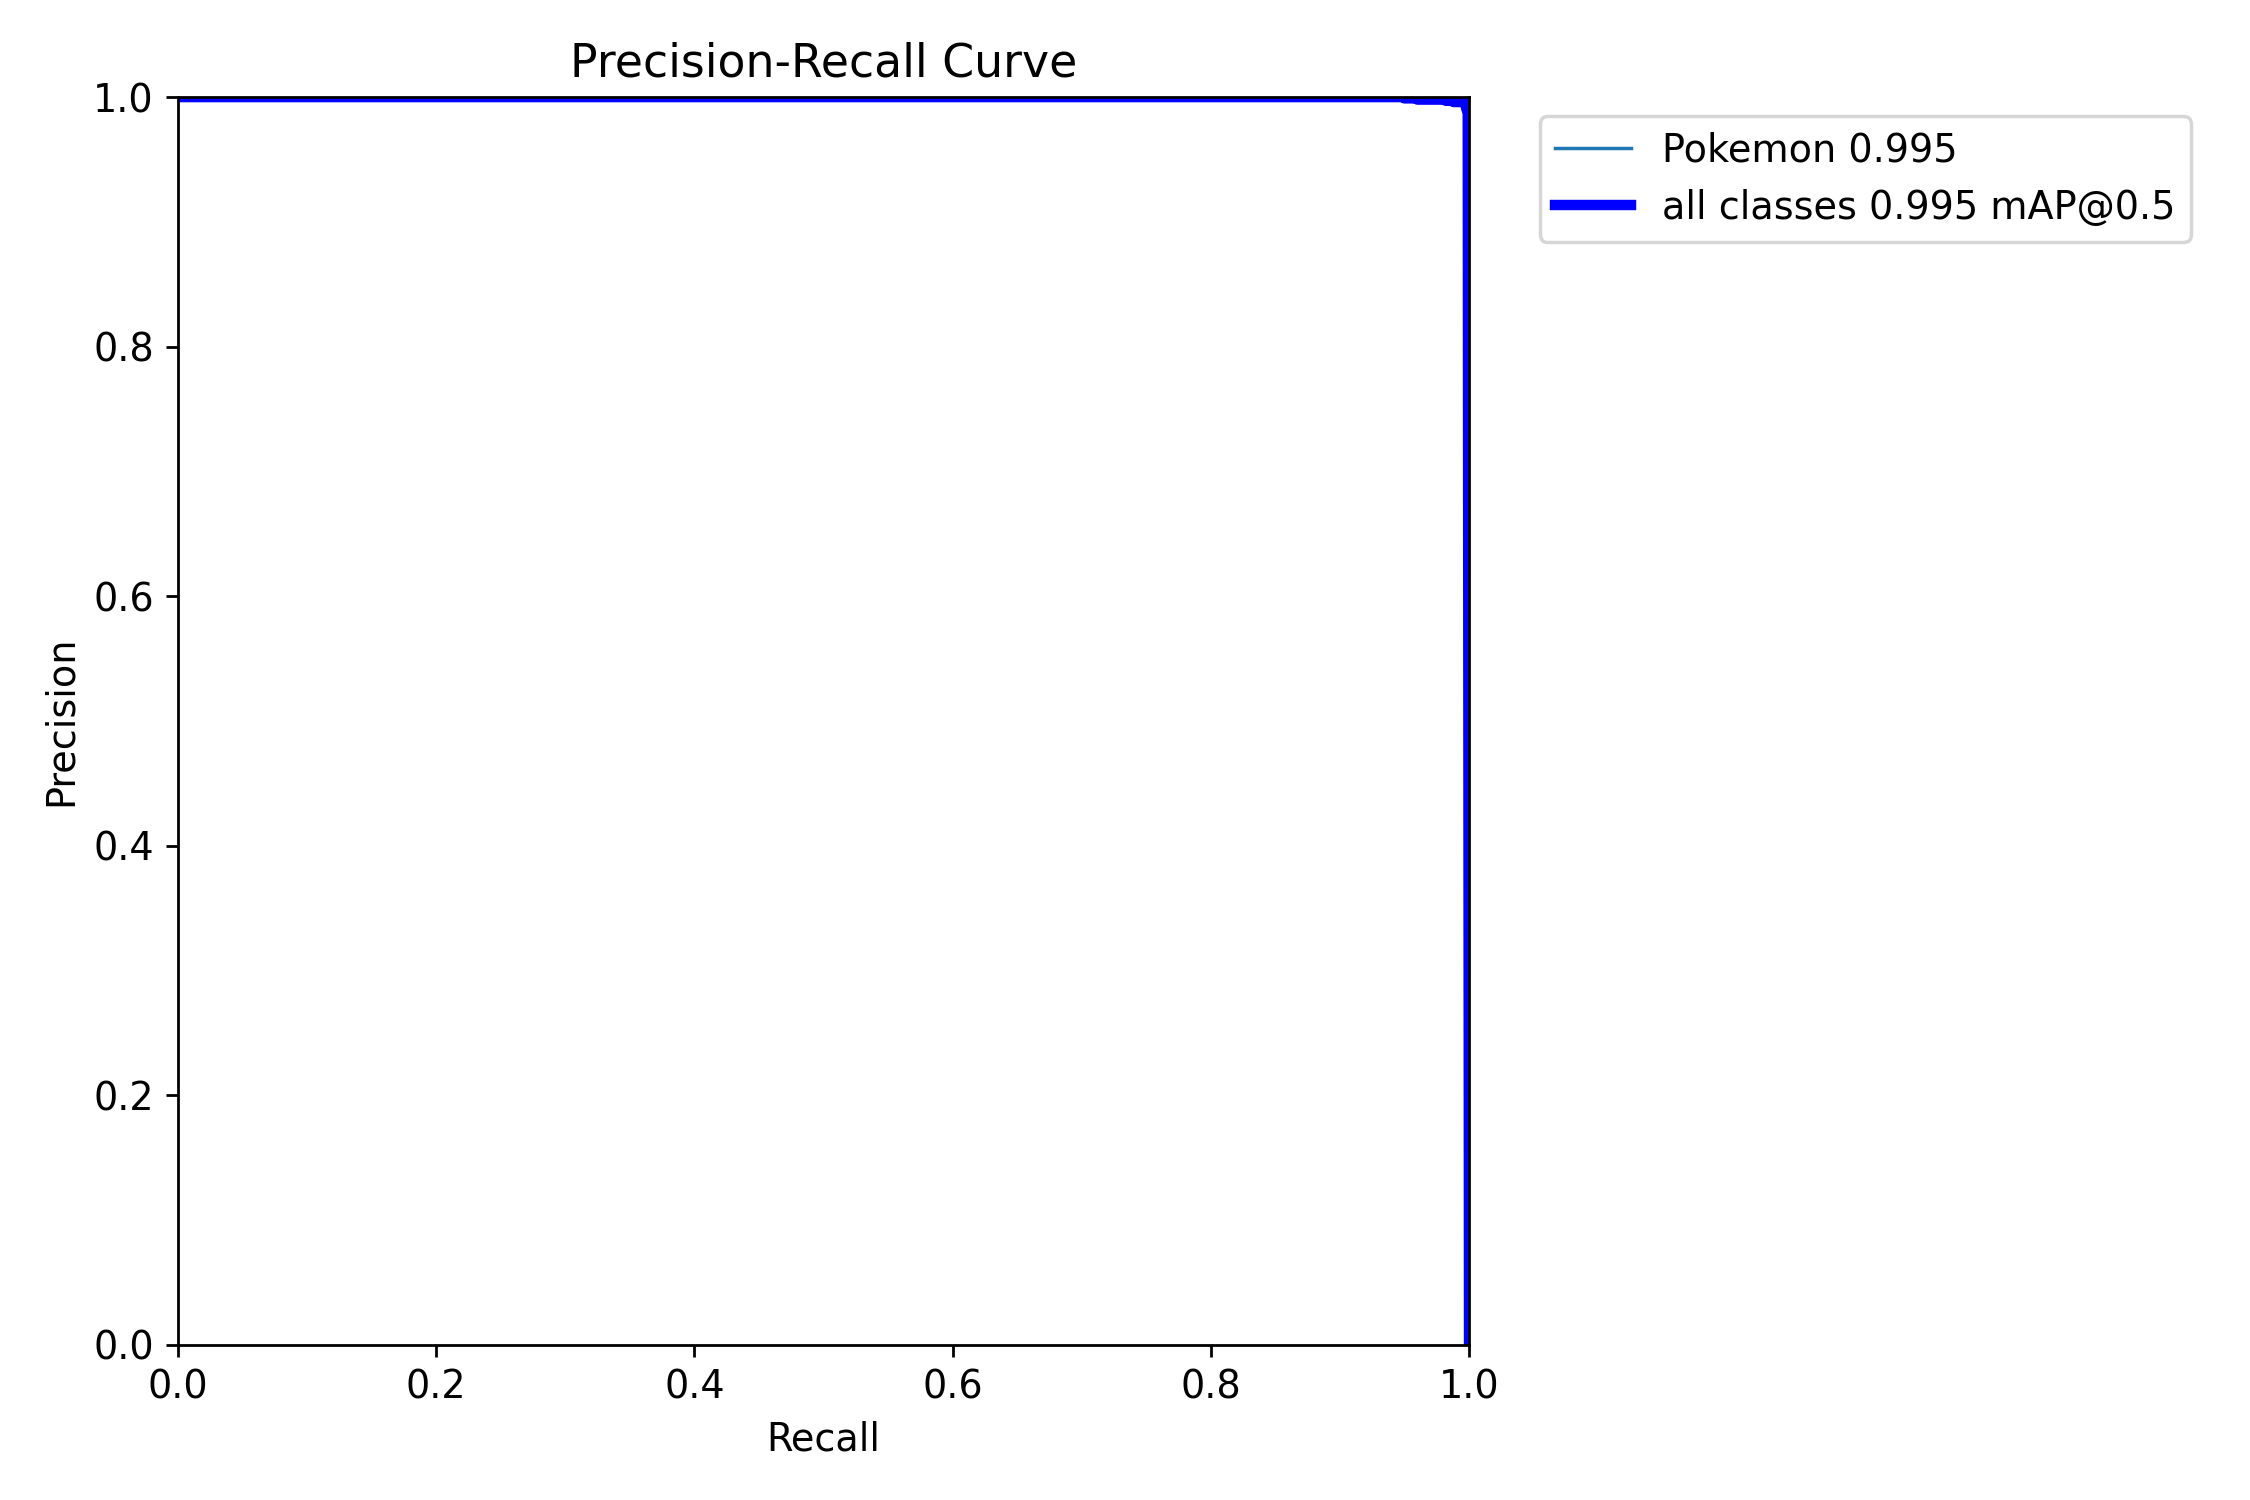
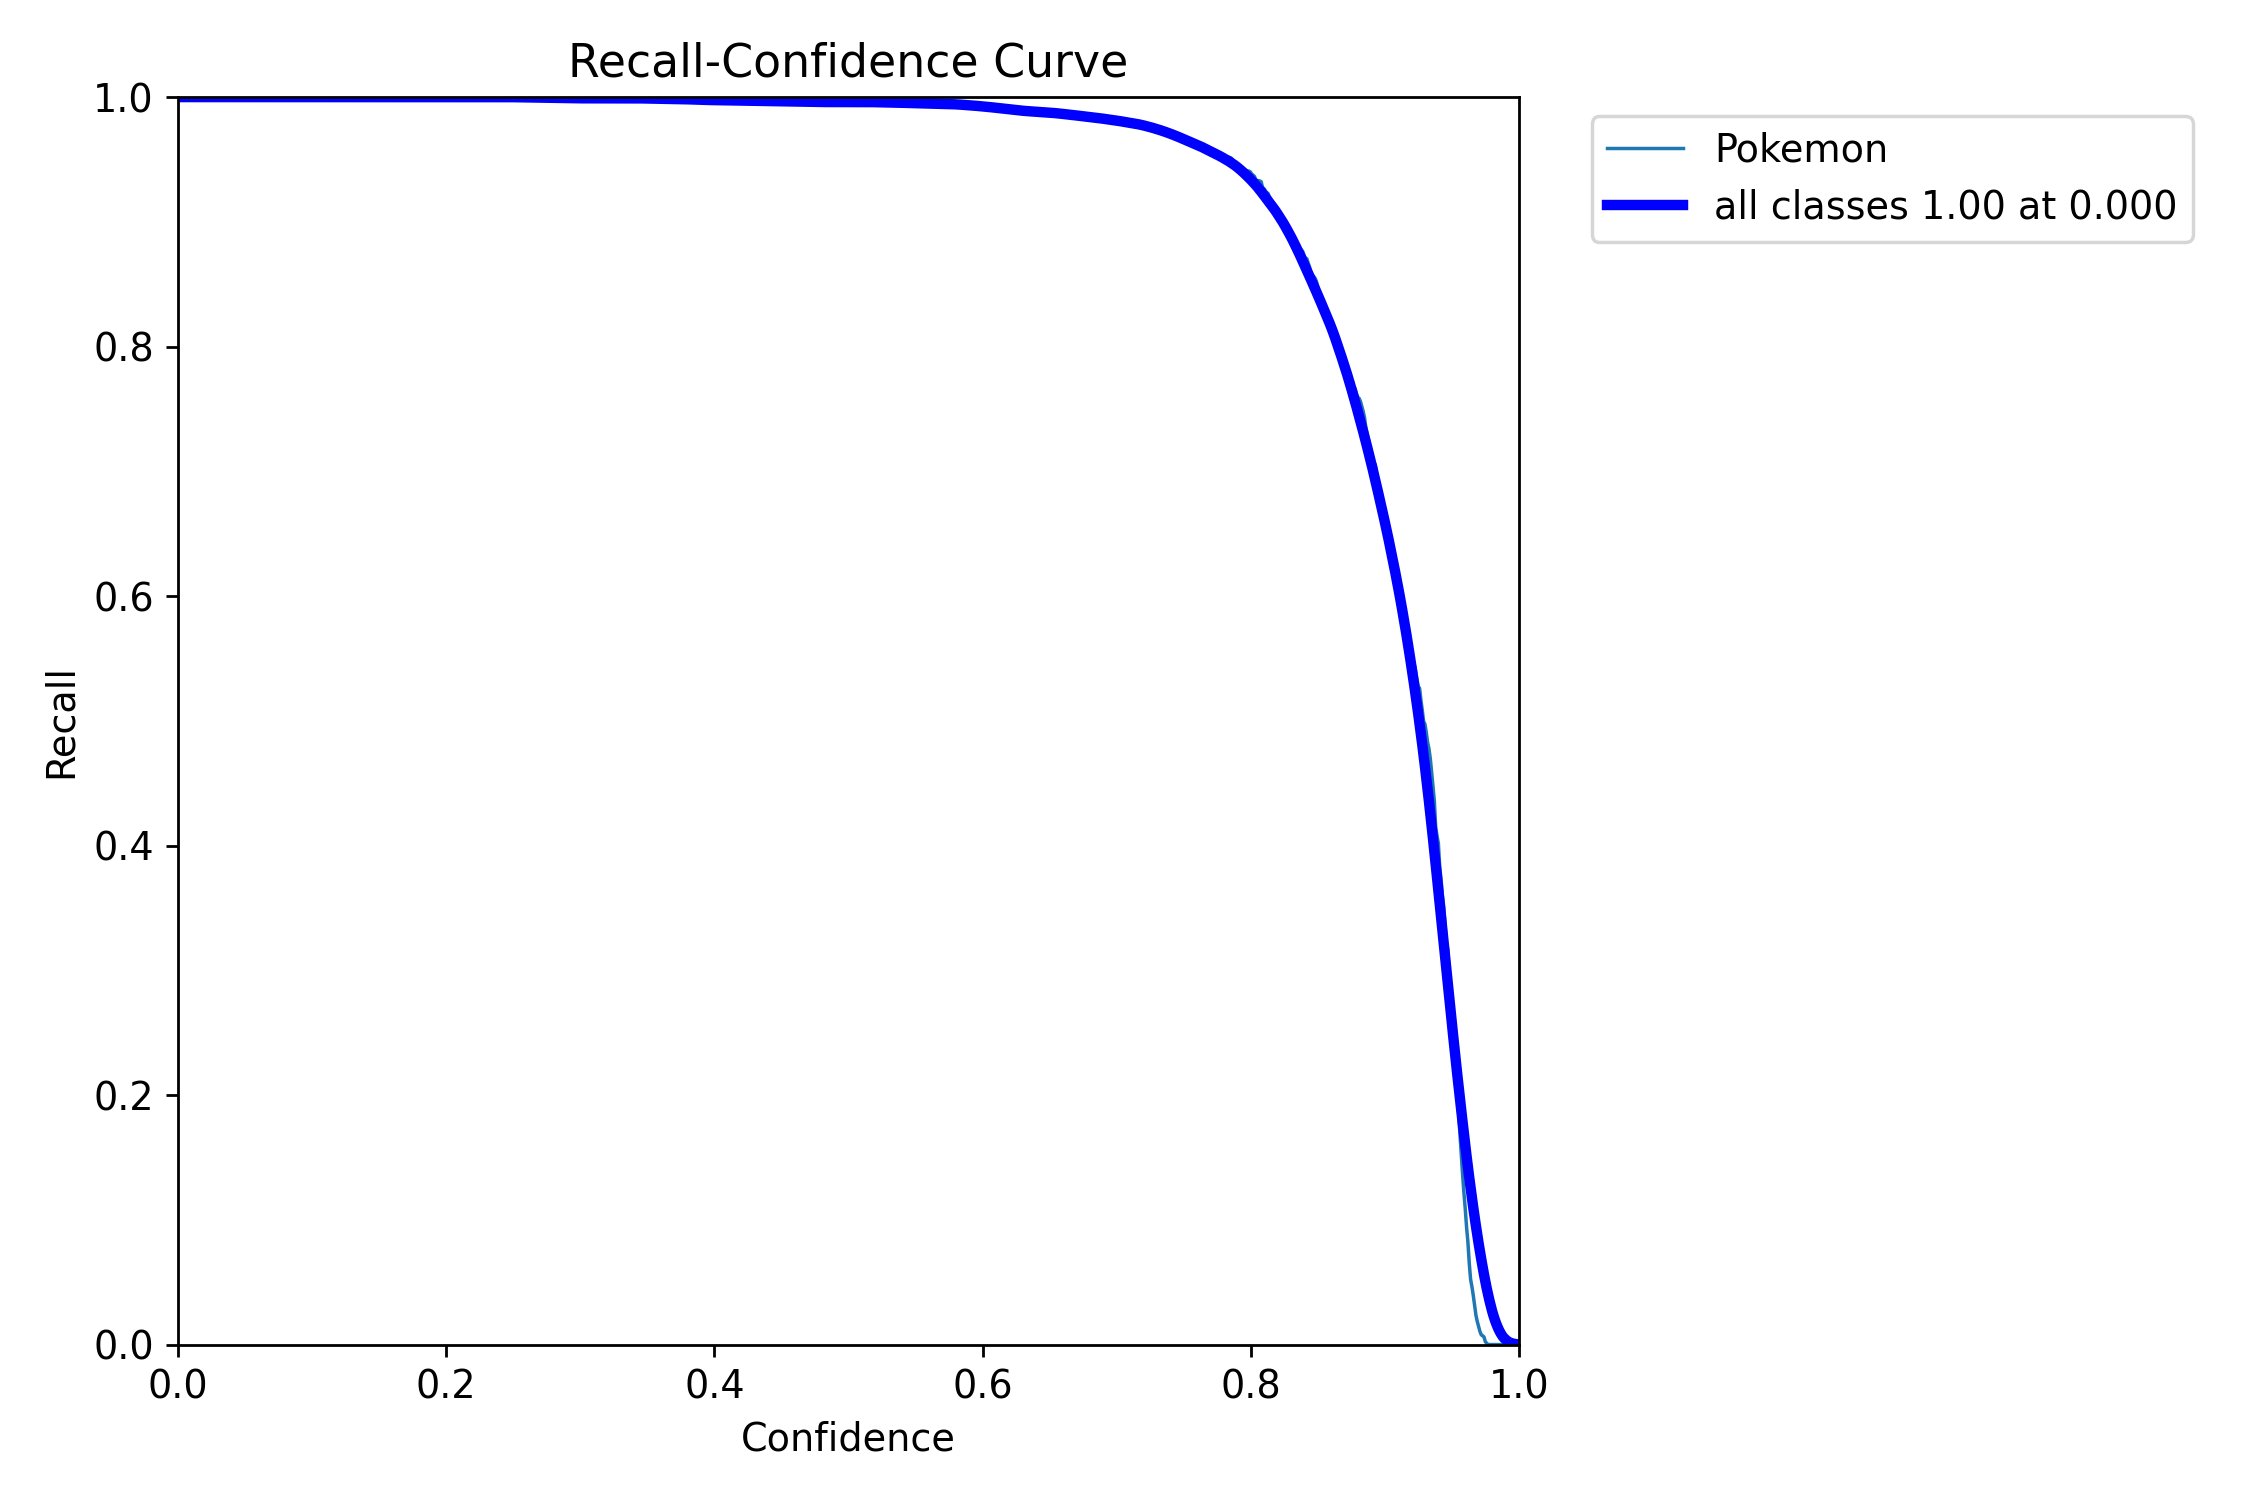
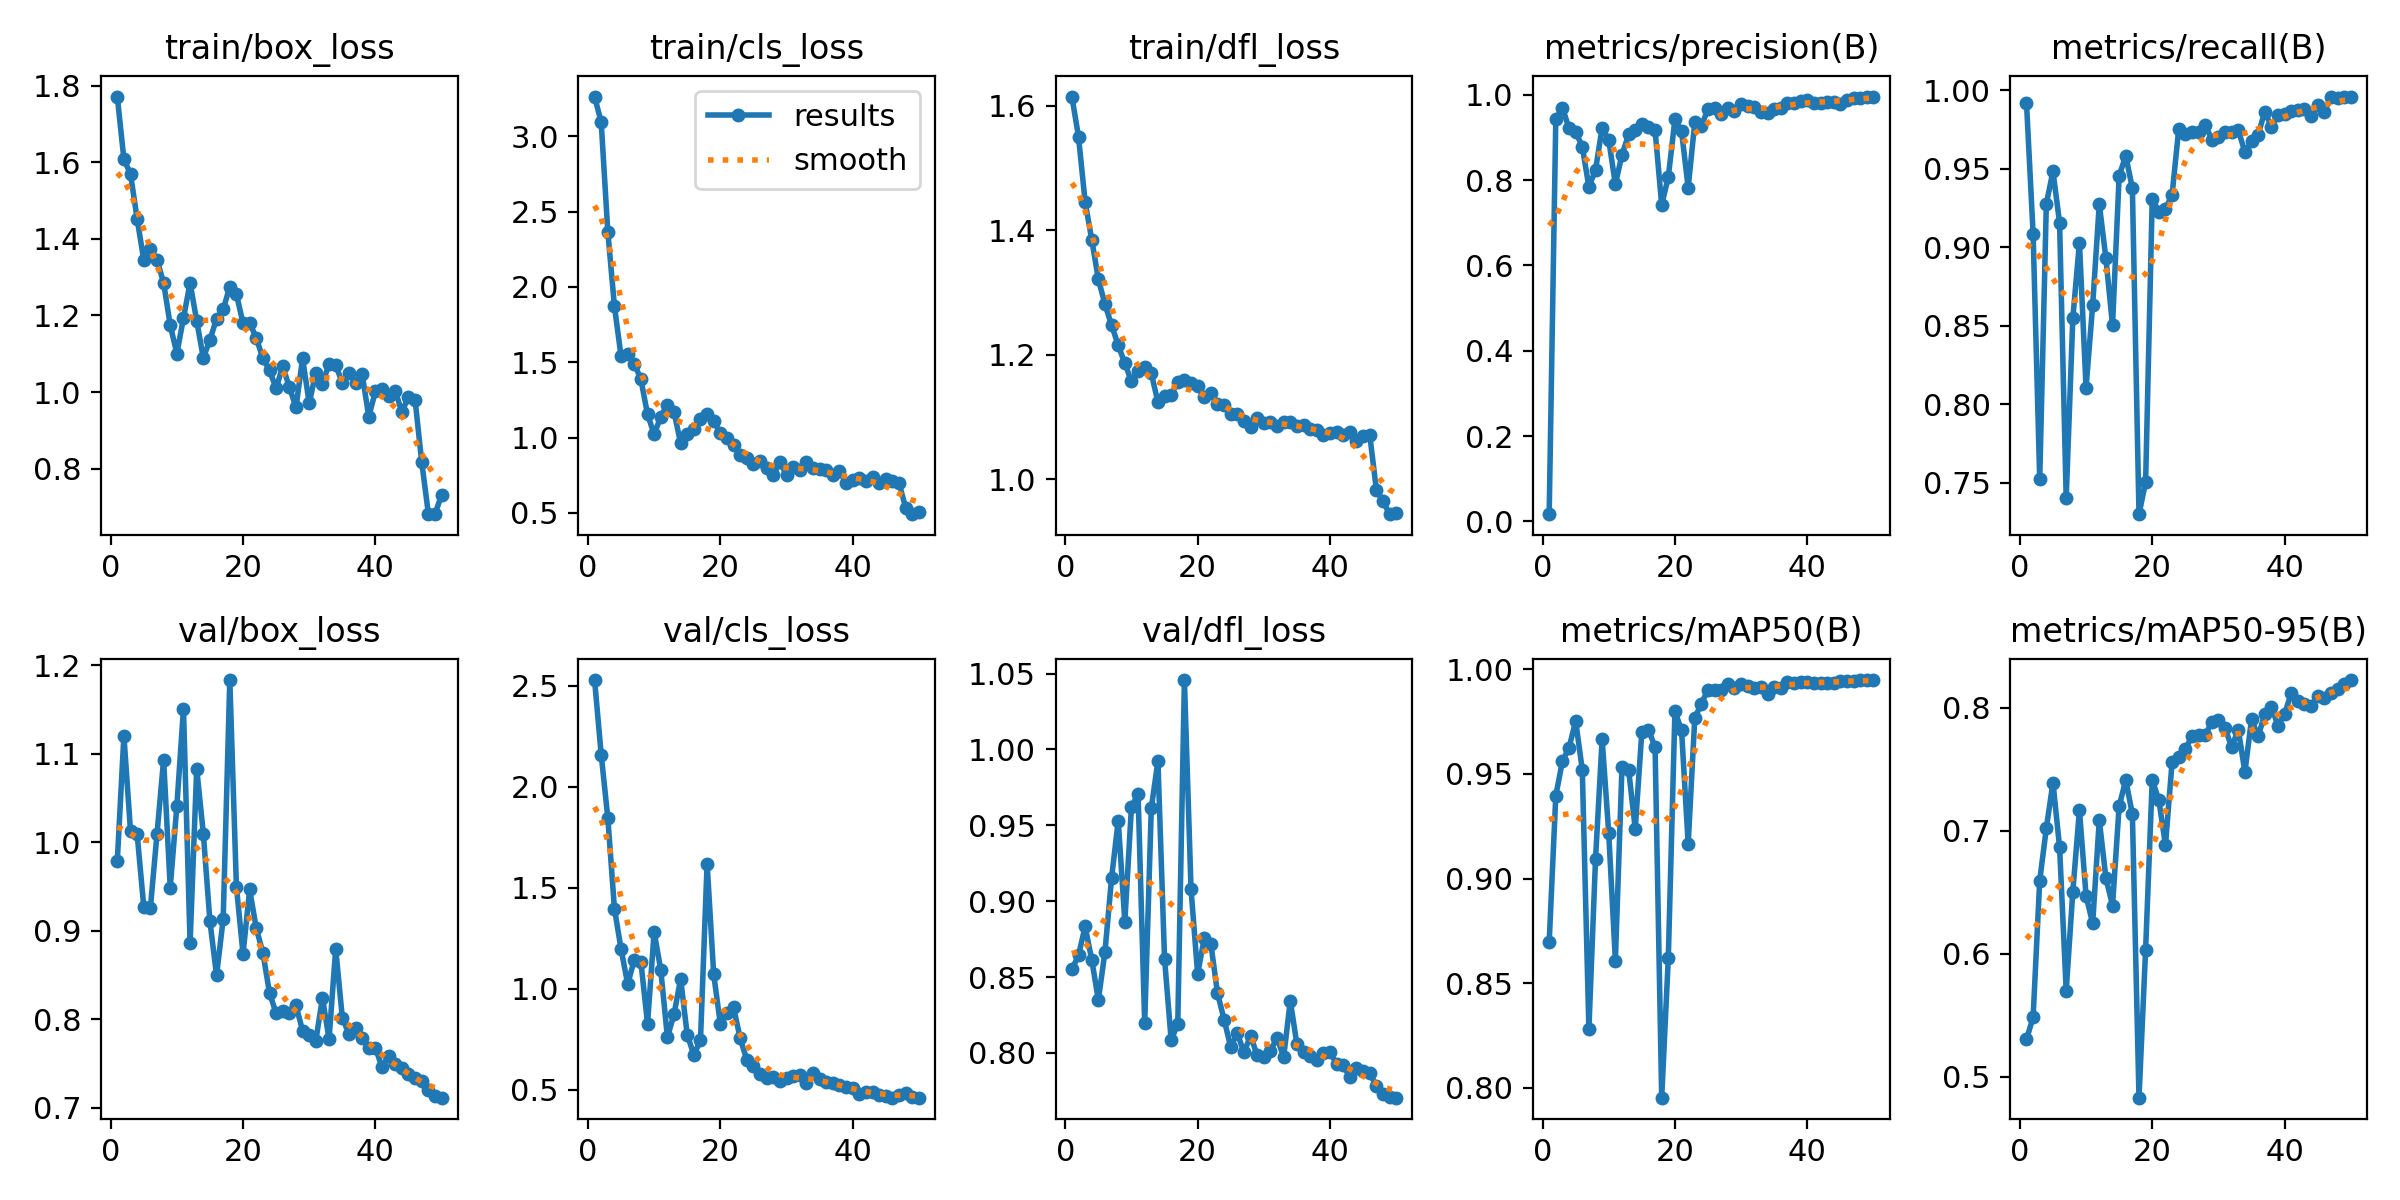

In [3]:
test_resaults=modelyolo.val(data="data.yaml", imgsz=128, batch=32,device=0,split='test',workers=4)

Ultralytics 8.3.73 🚀 Python-3.12.7 torch-2.7.0.dev20250207+cu128 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/omerd/dlfinalprojmerged/test/labels.cache... 1974 images, 0 backgrounds, 0 corrupt: 100%|███████
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00


                   all       1974       1974      0.994      0.999      0.995       0.82
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/vovodtransfer202


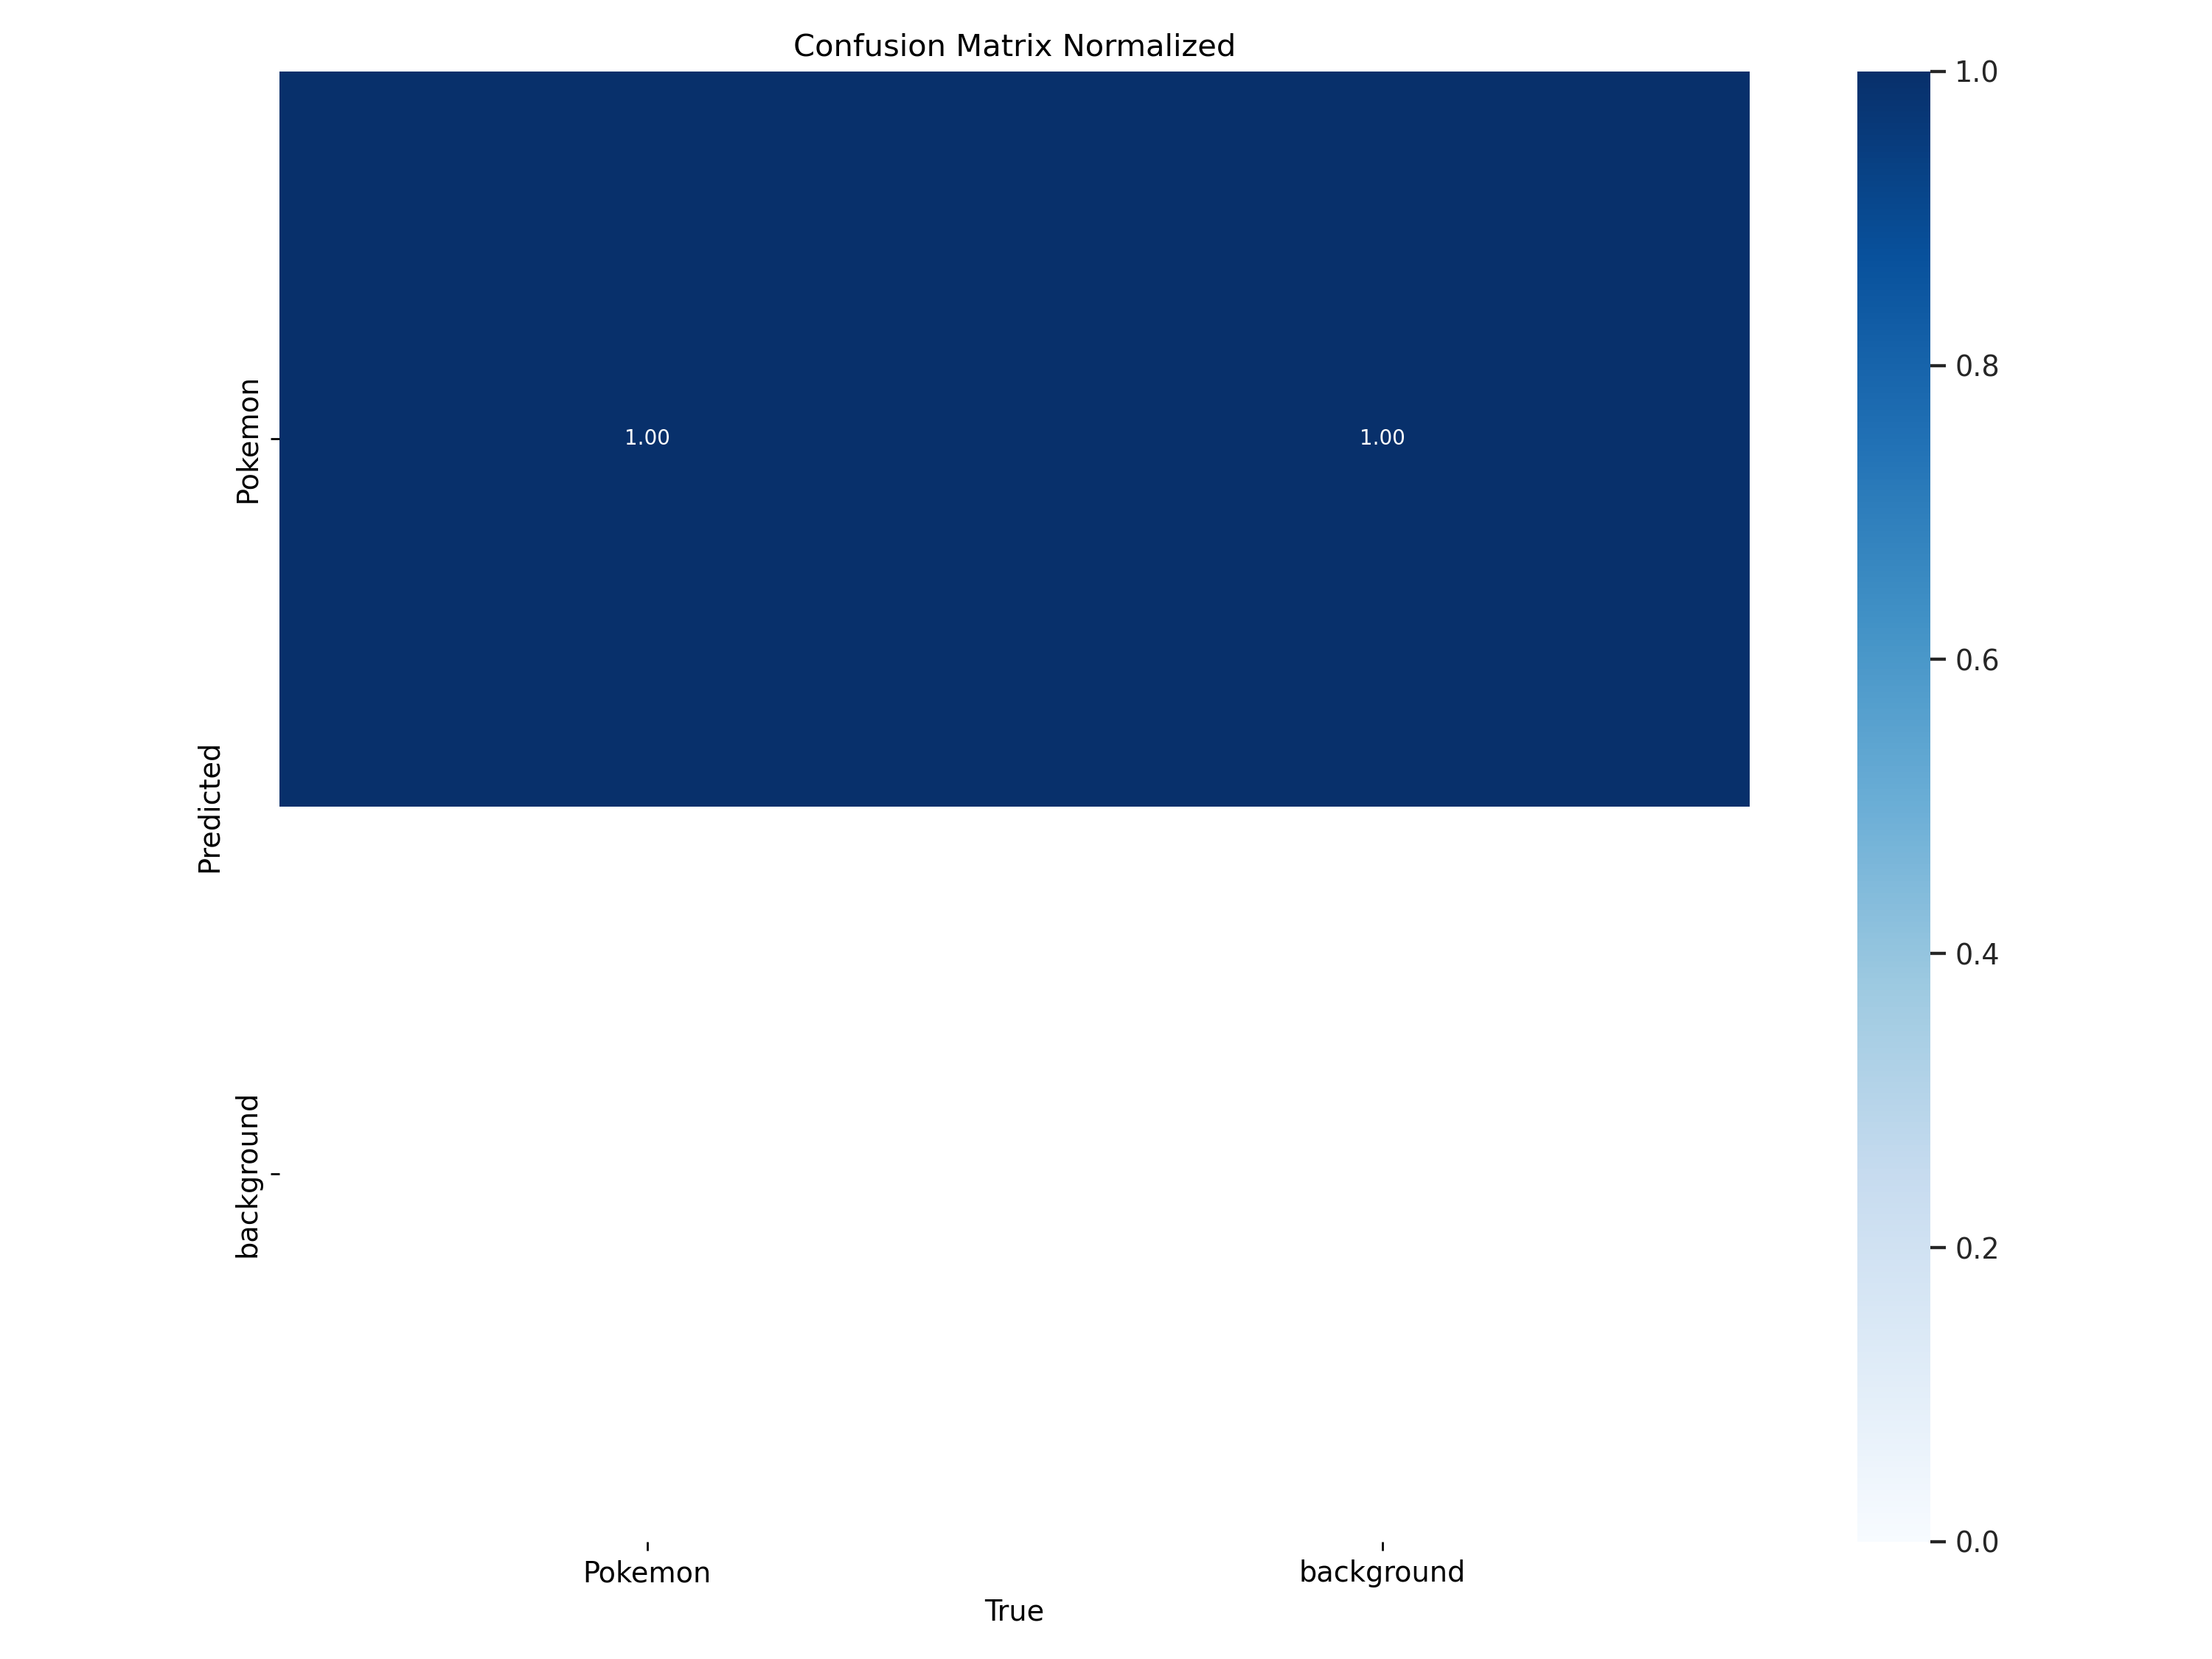

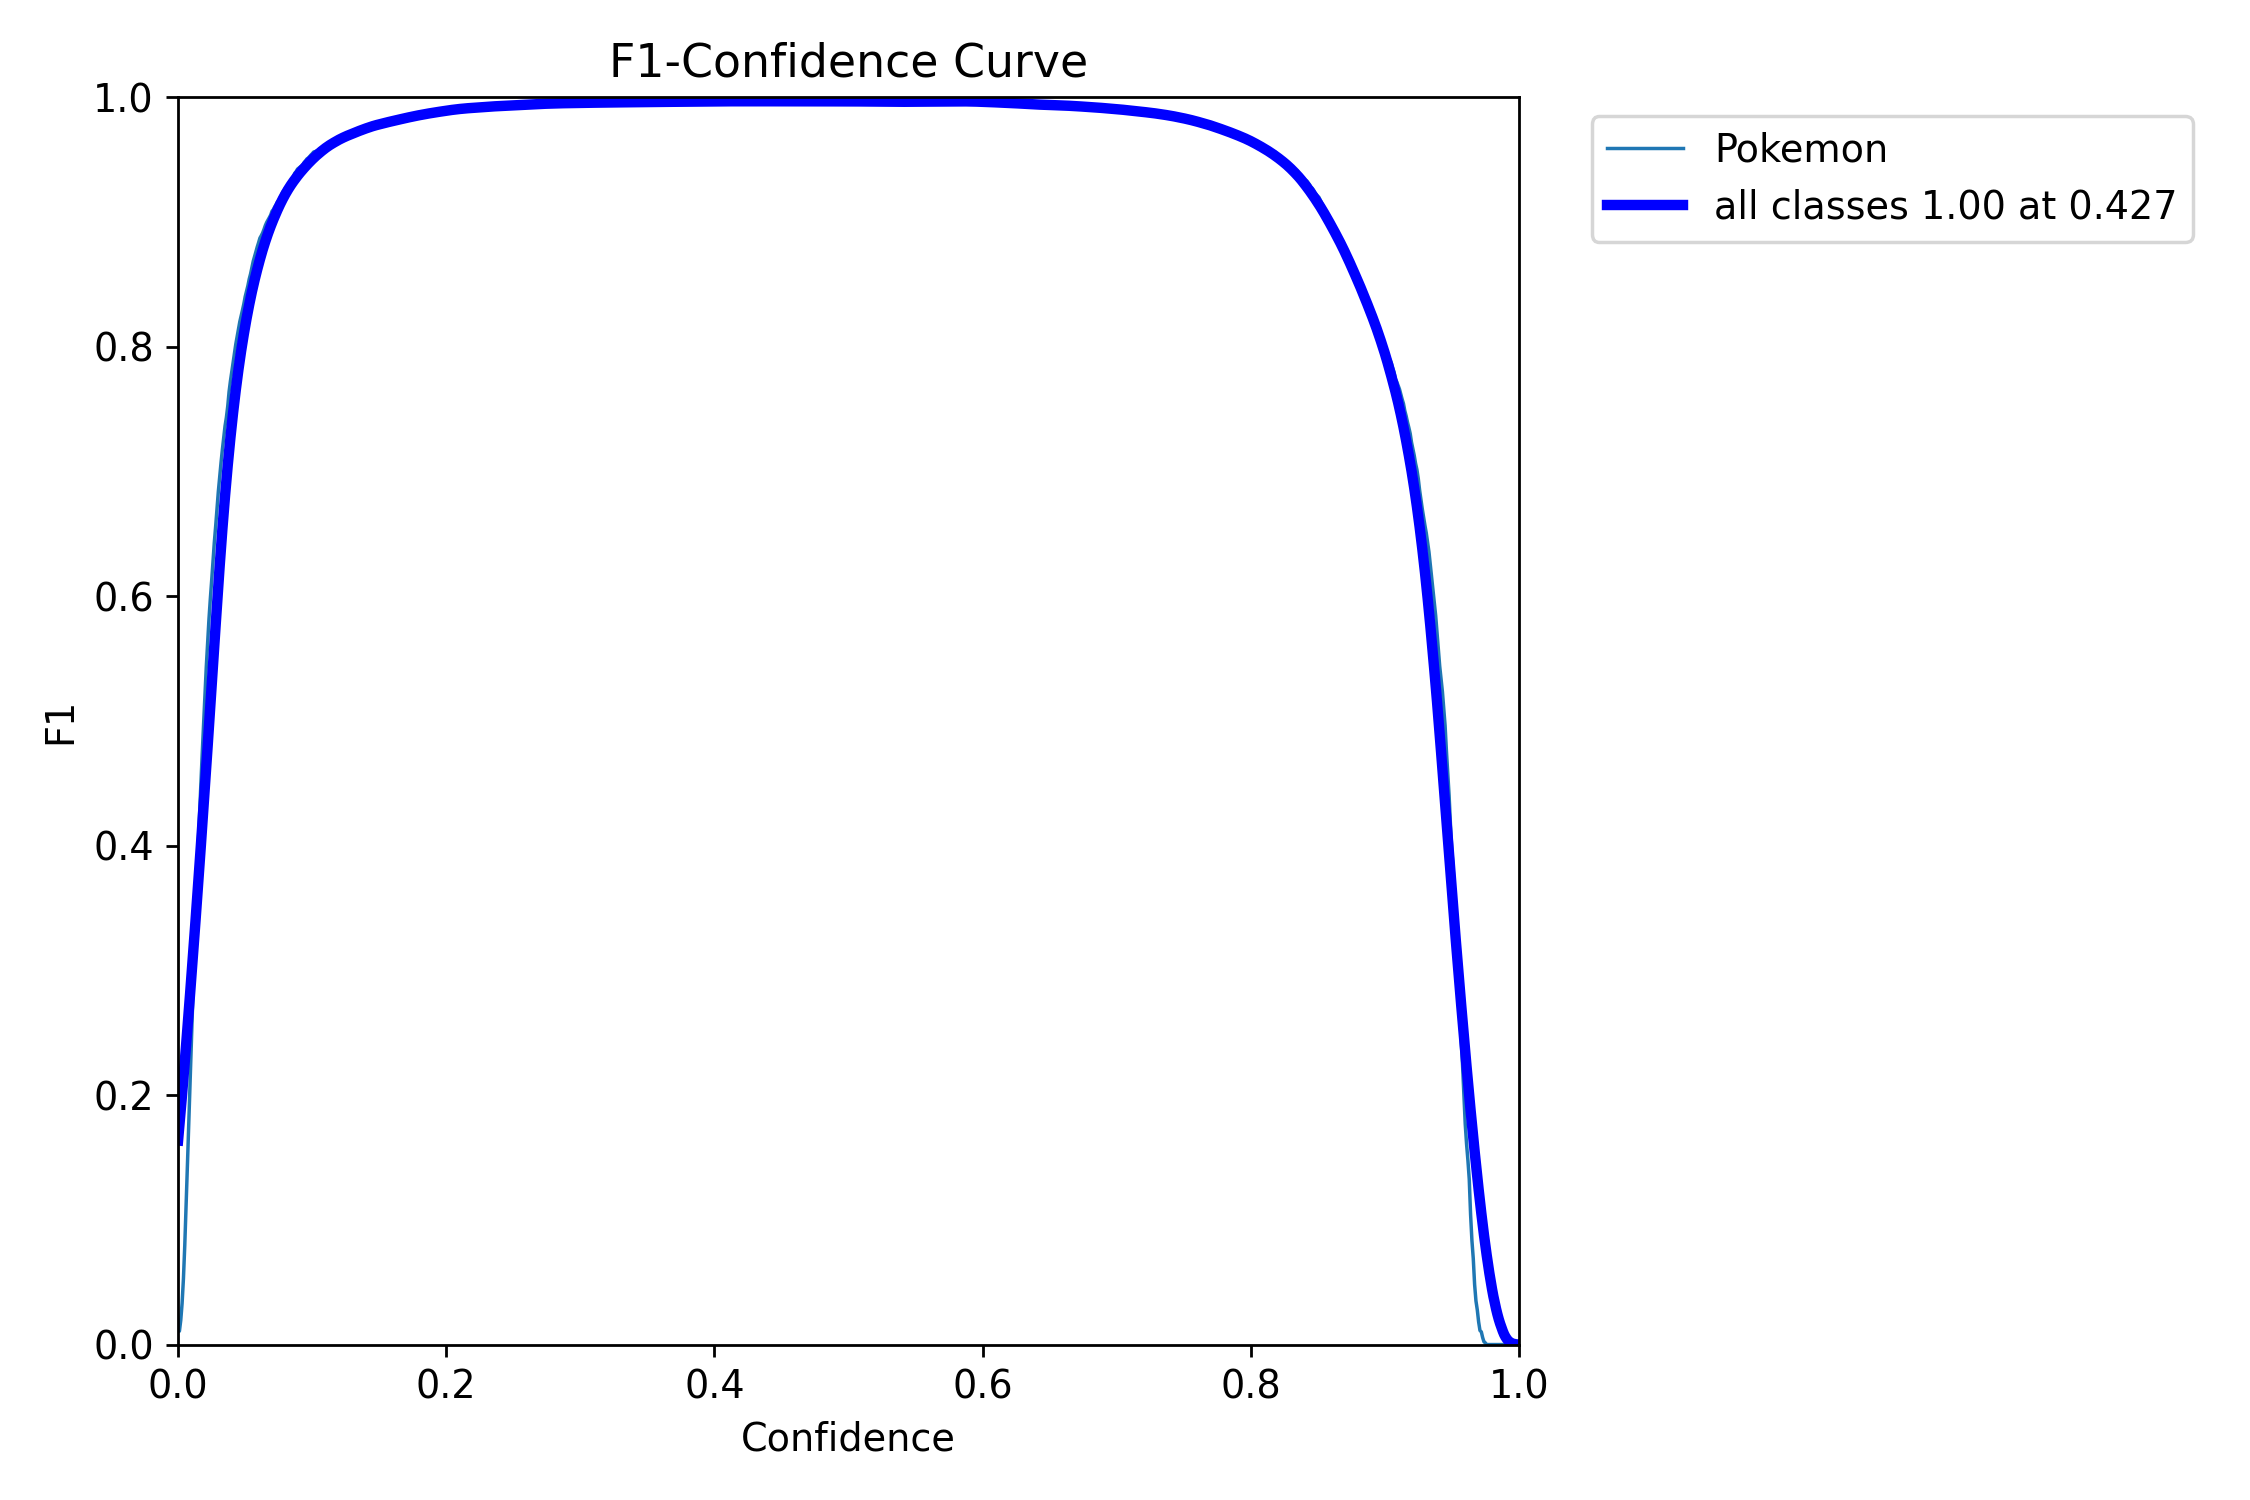

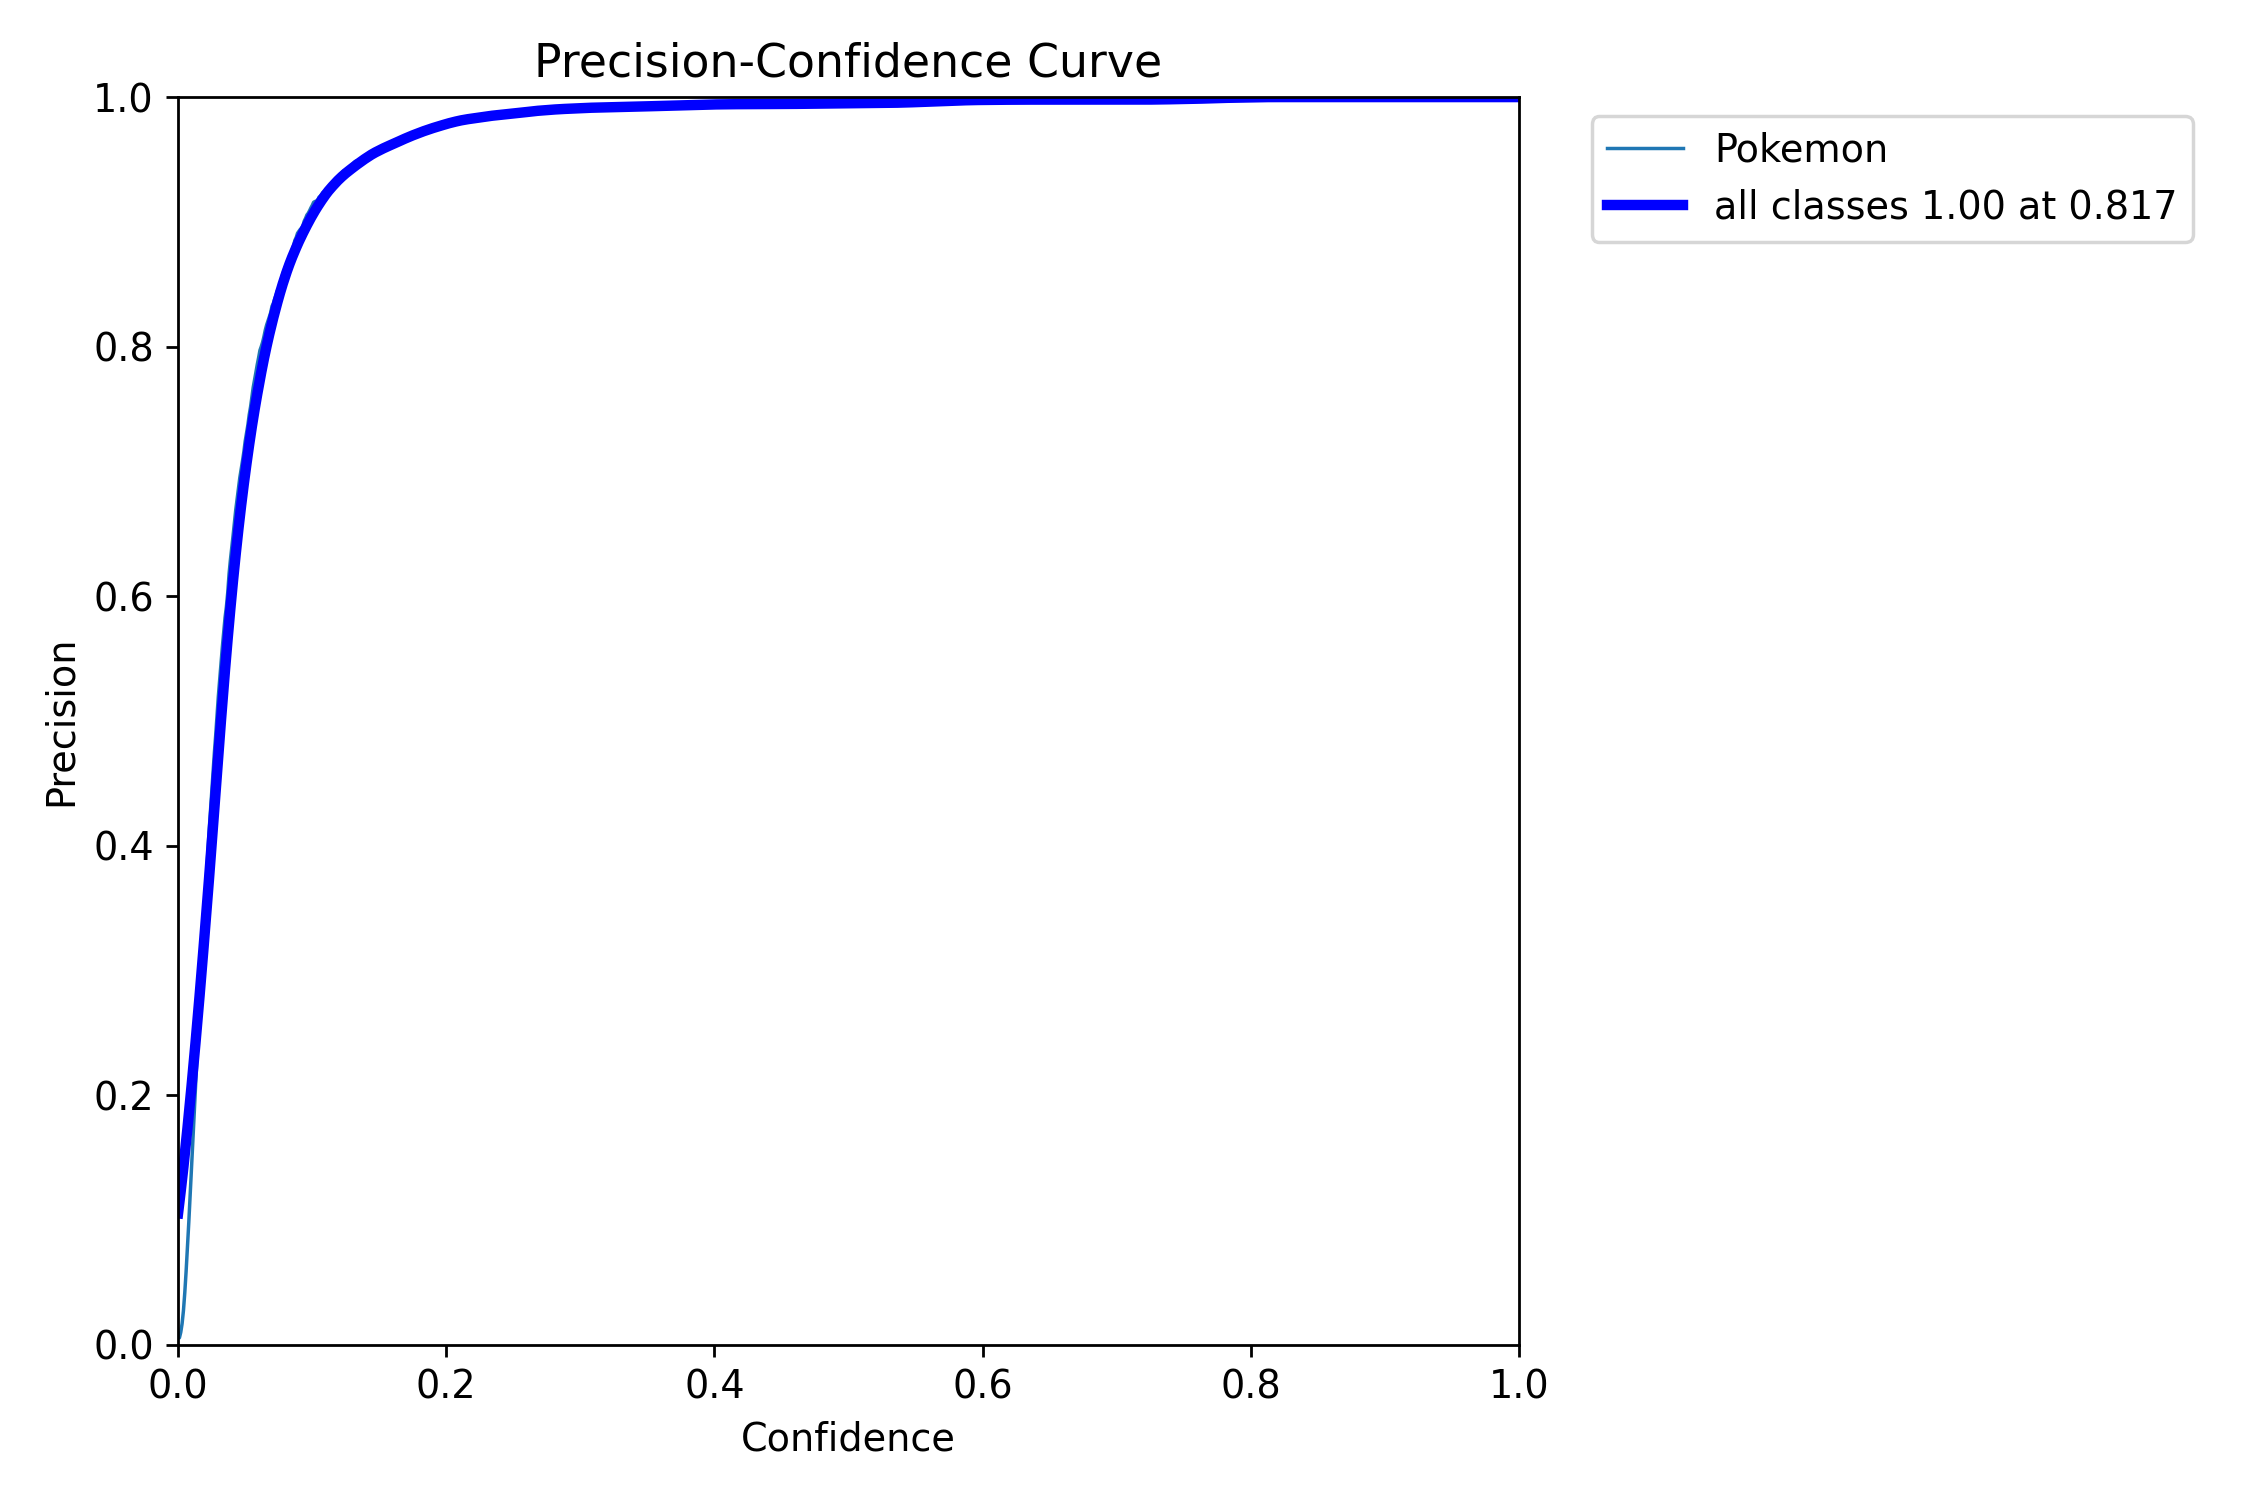

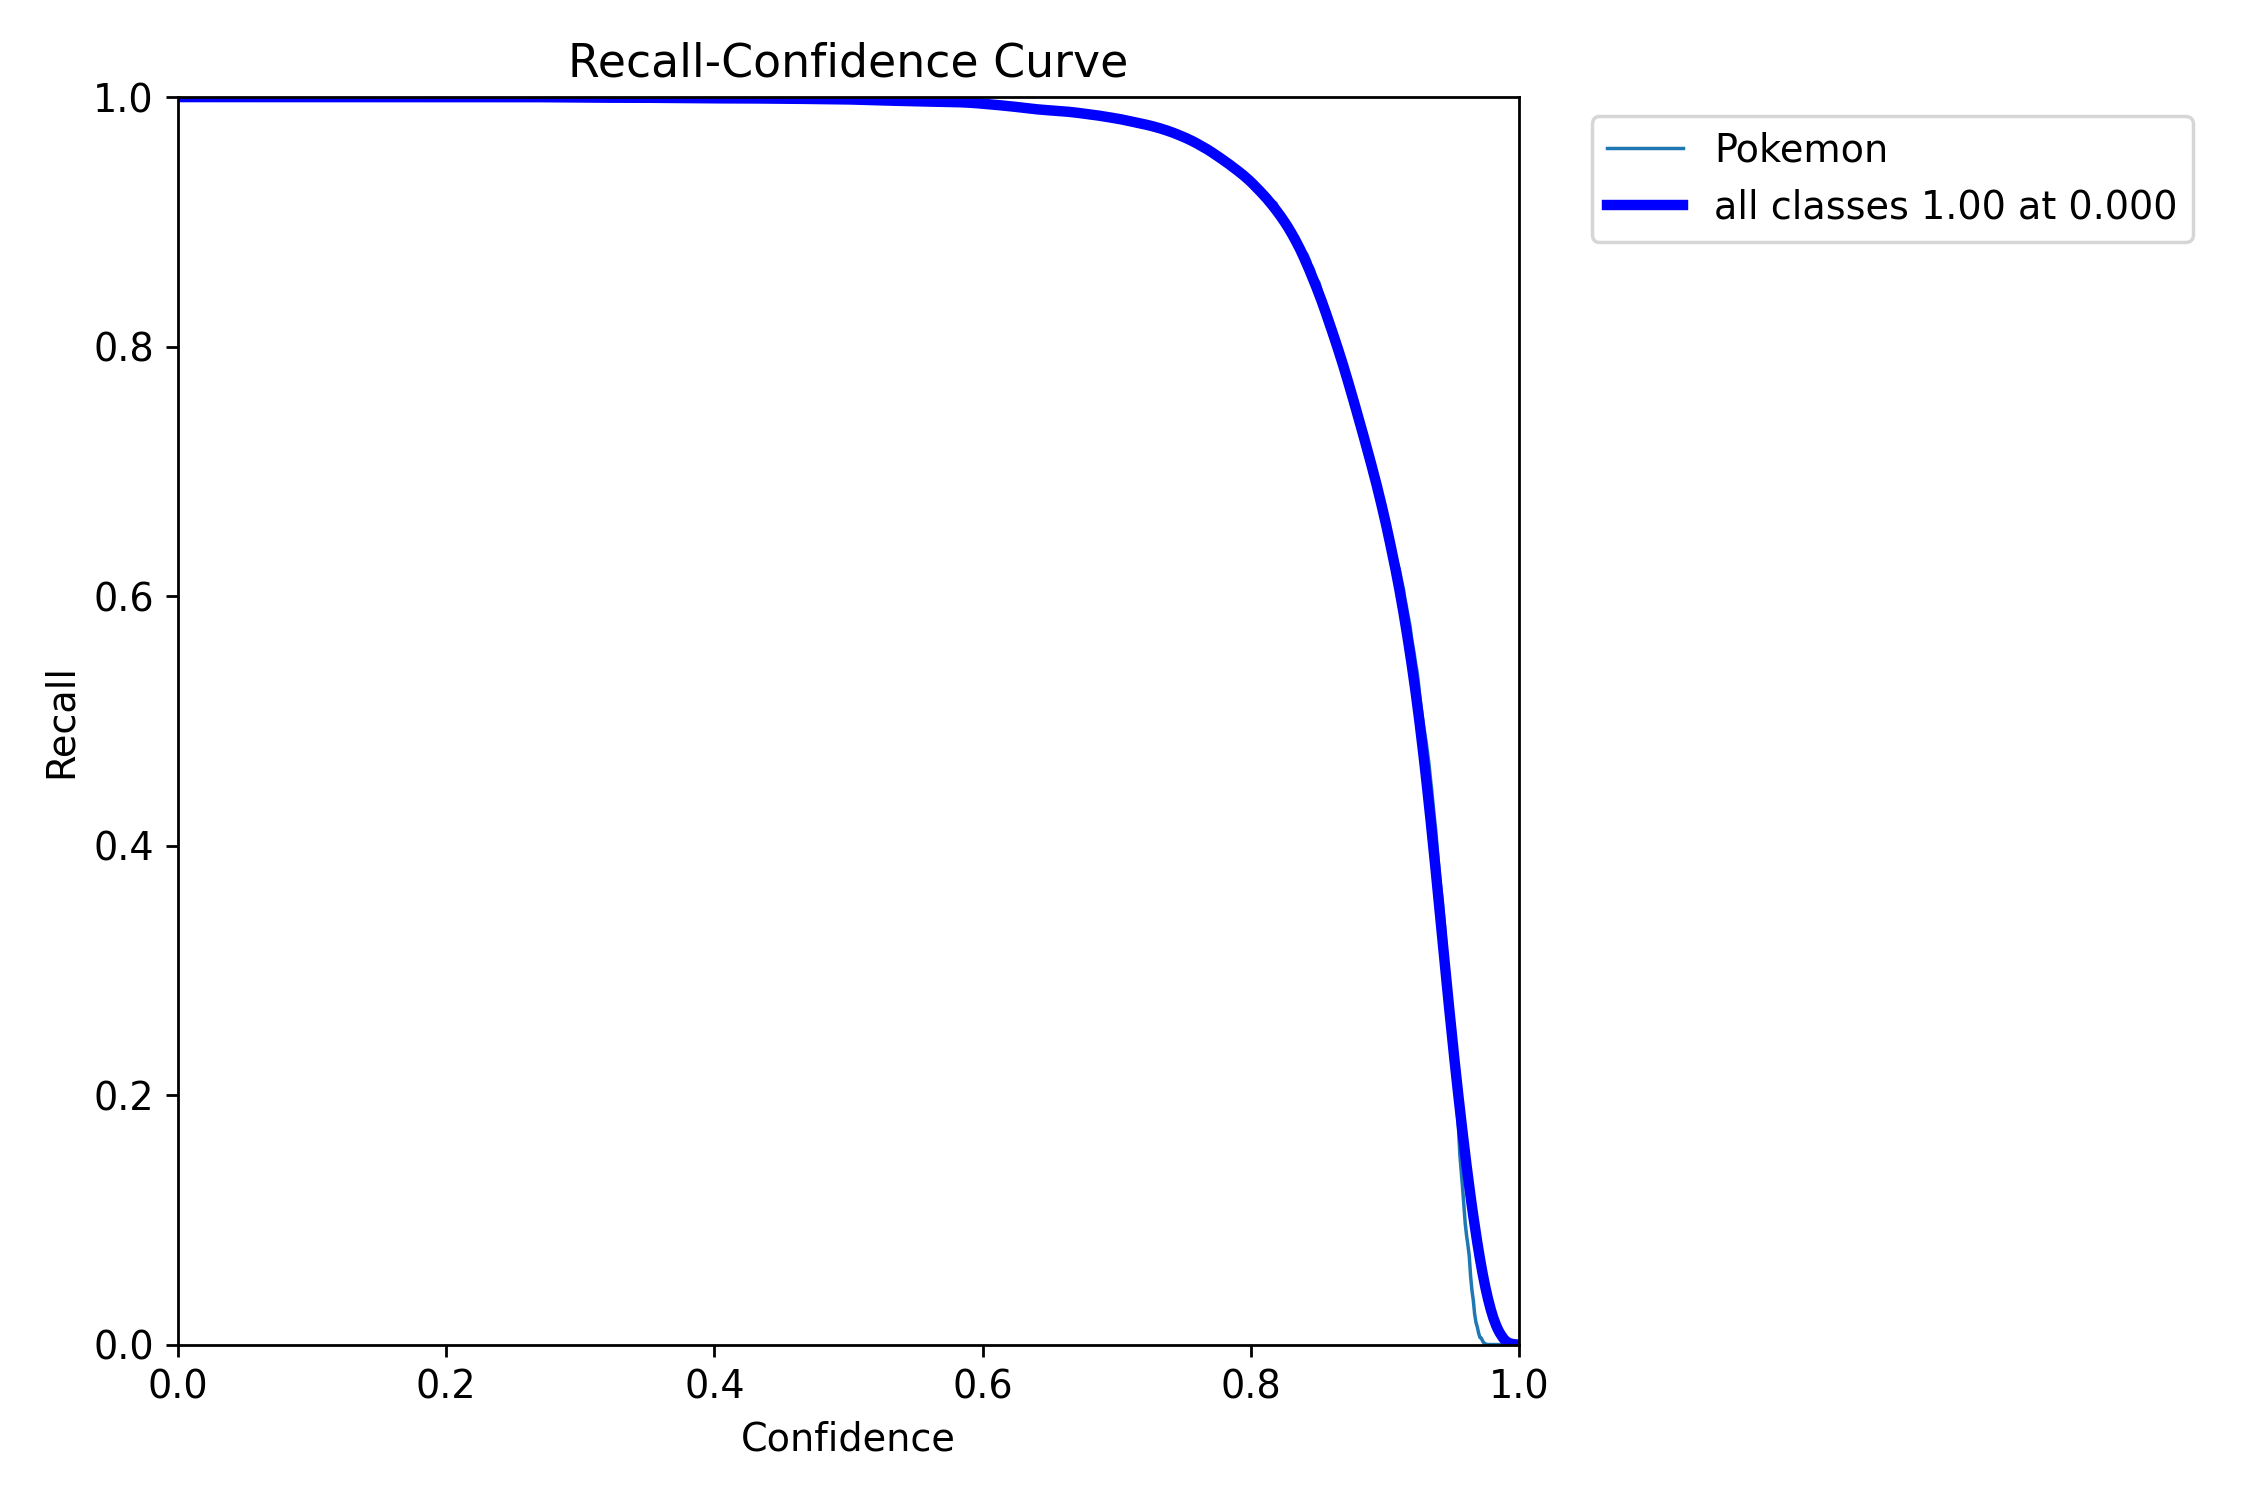

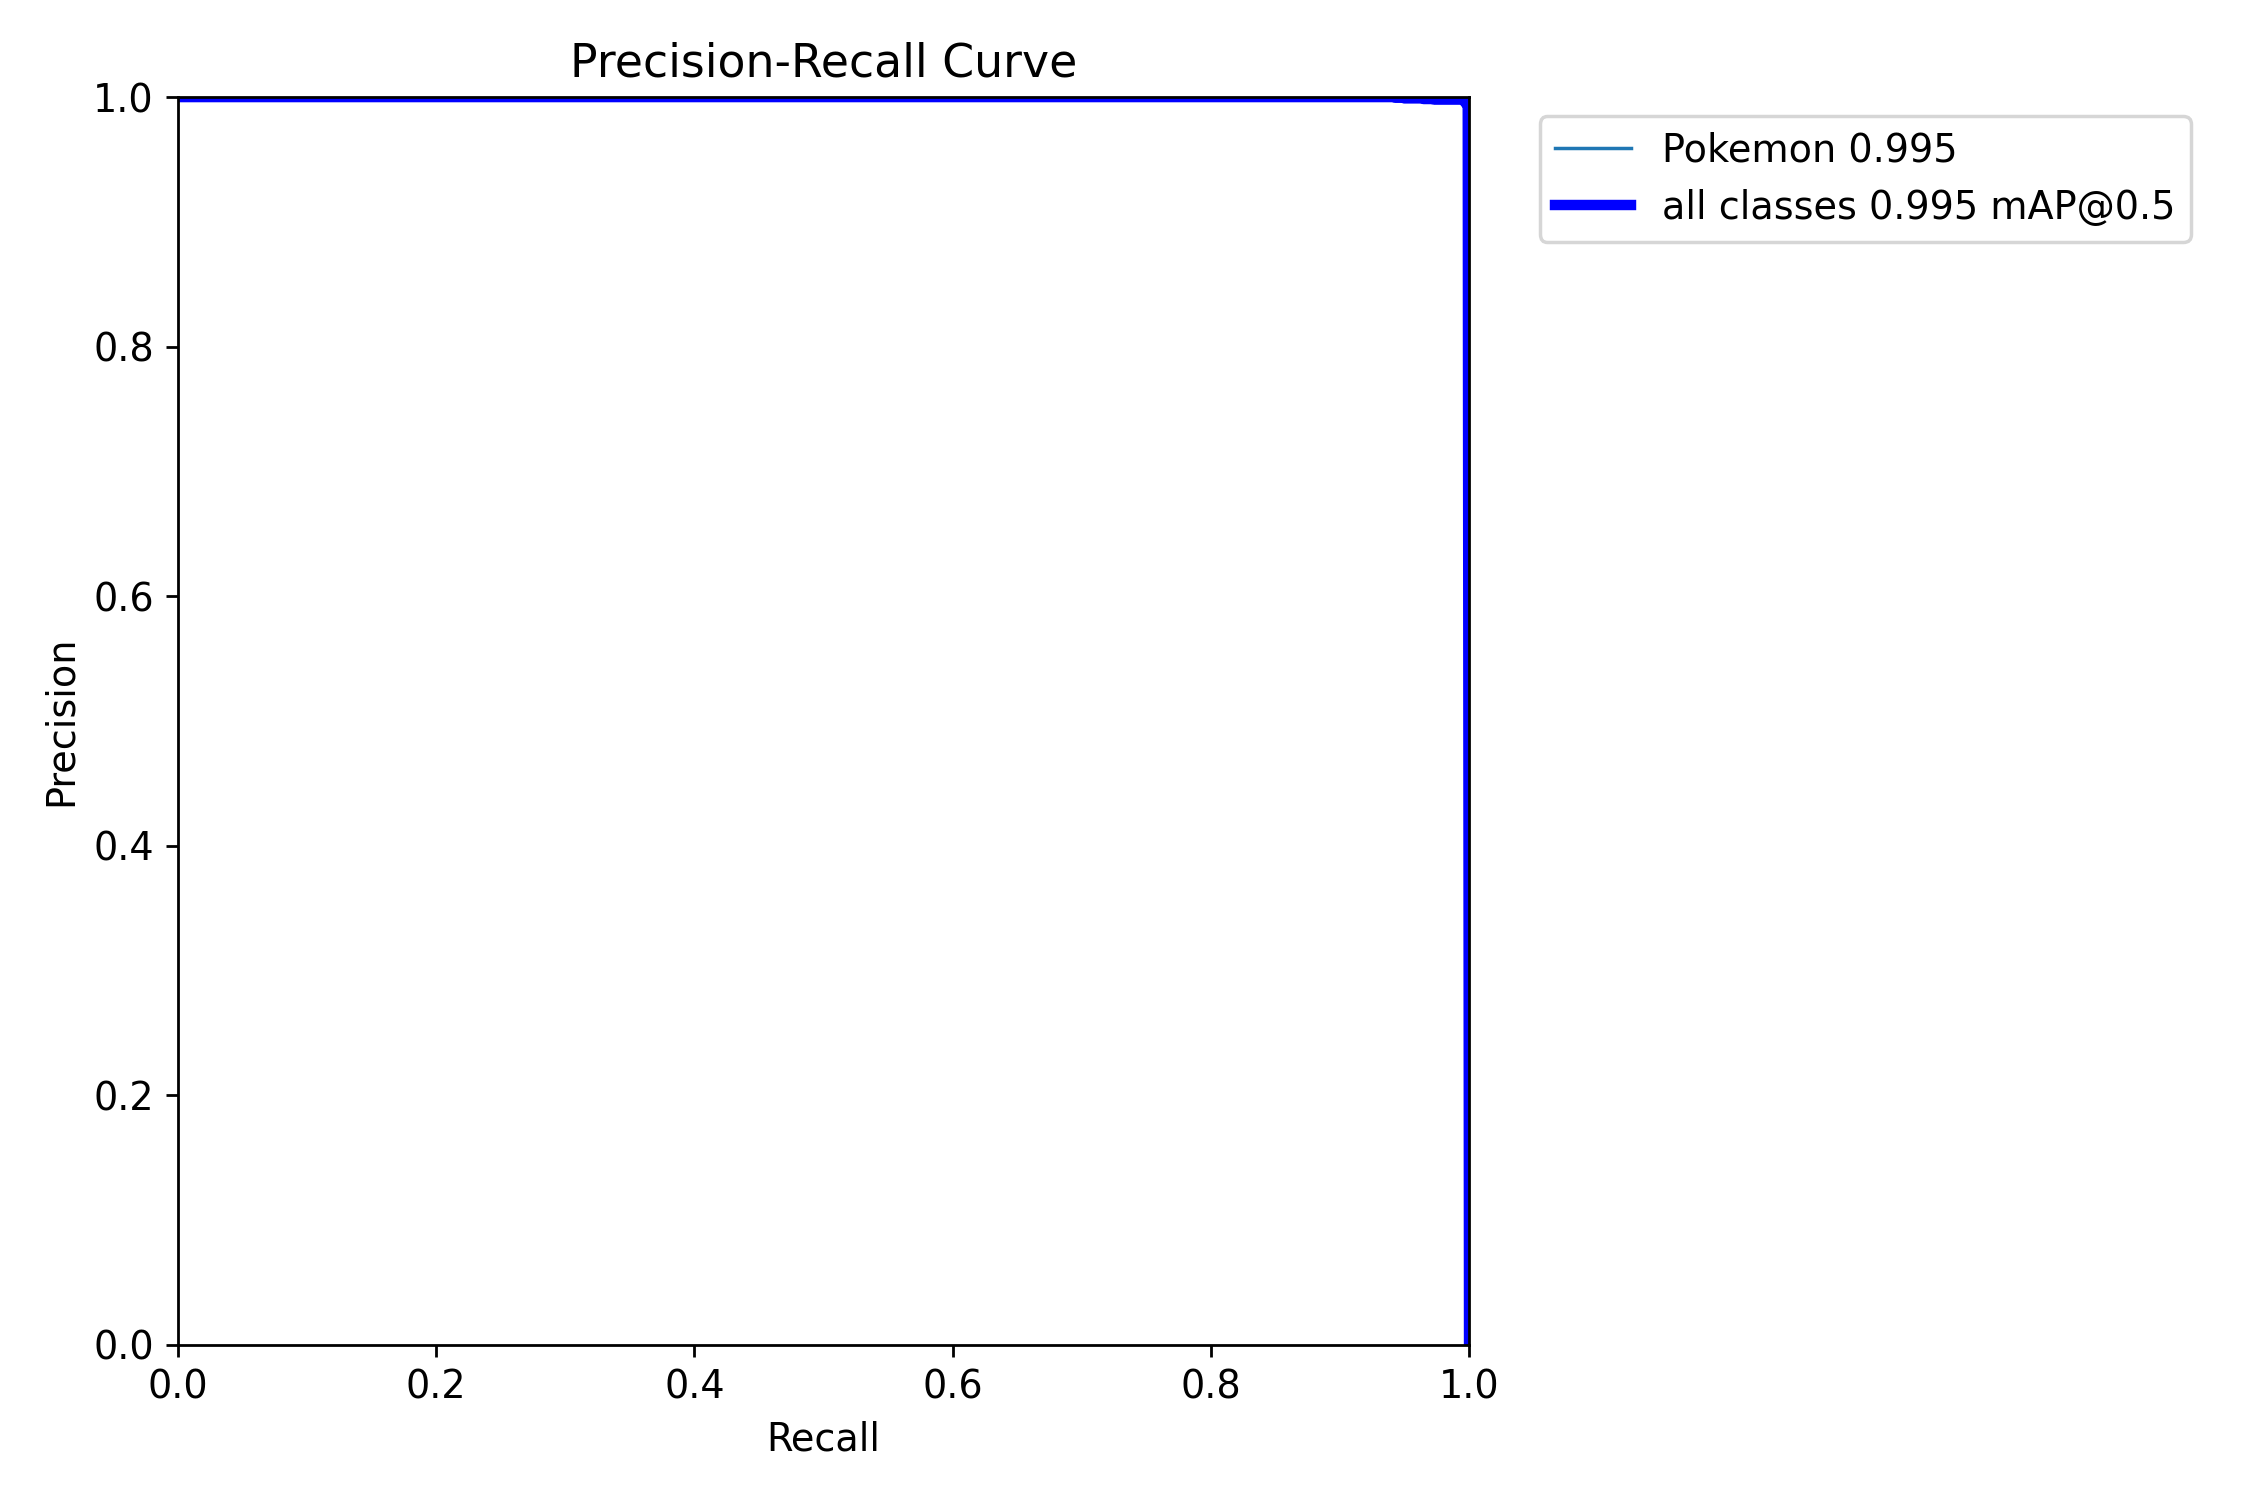


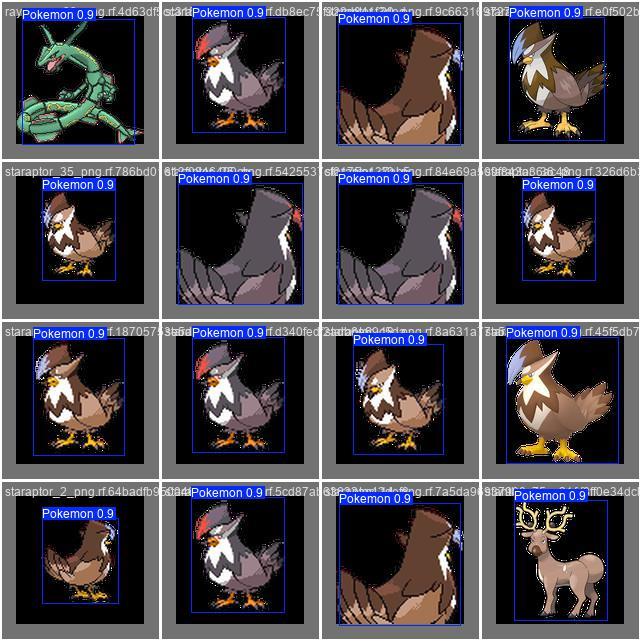
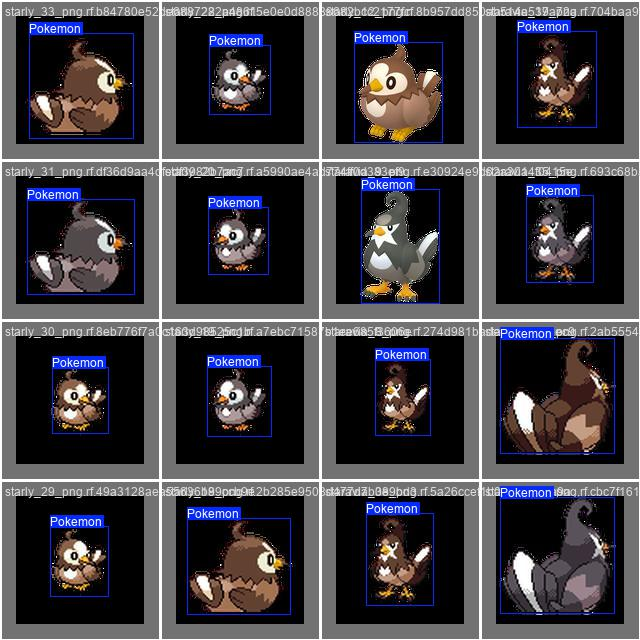
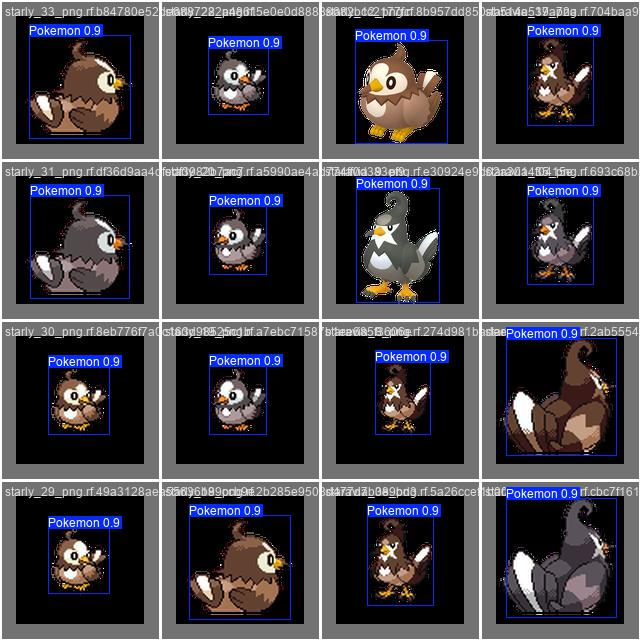
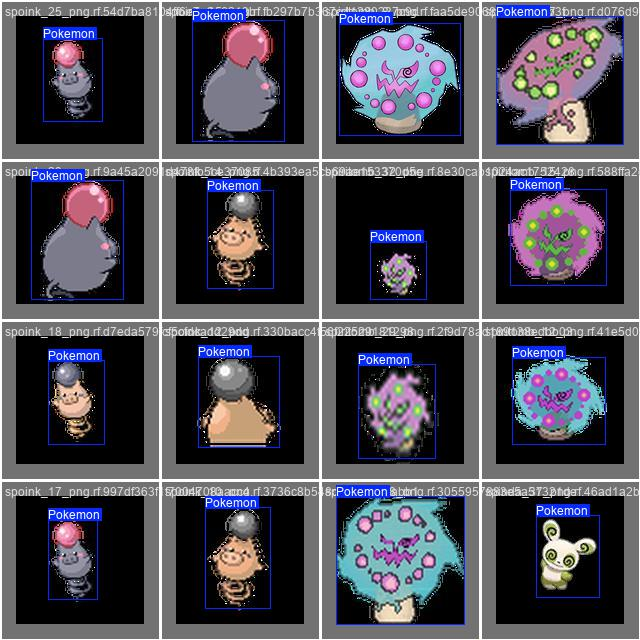
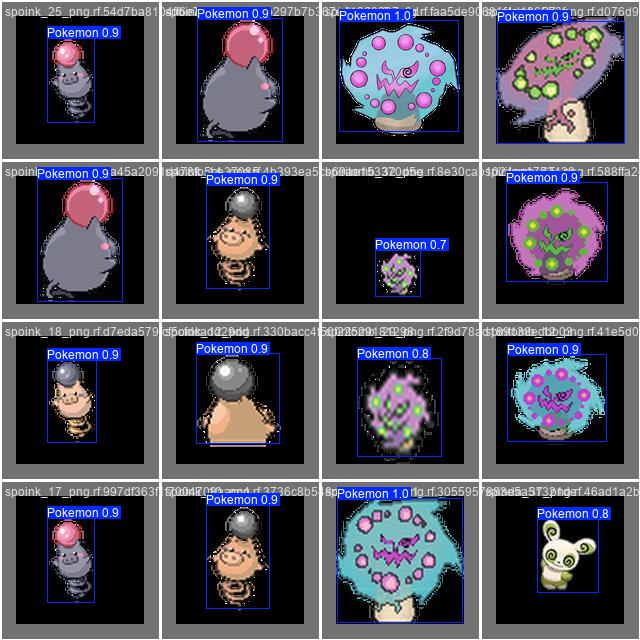
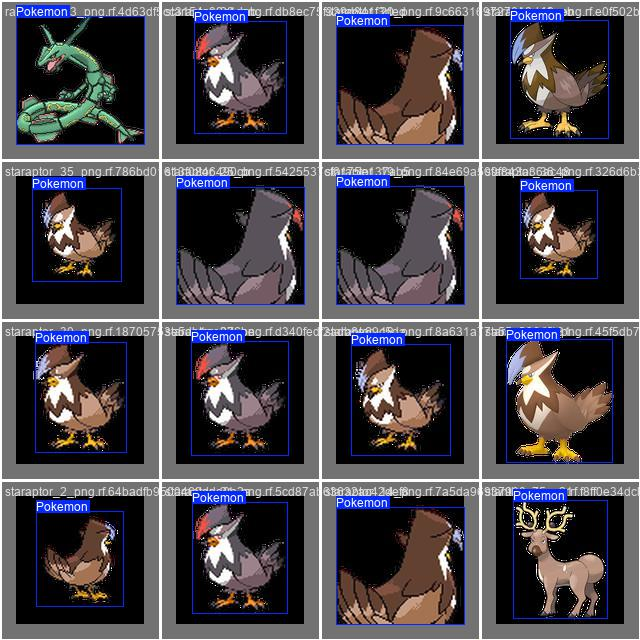

In [4]:
#Transform wrapper
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  #Convert PIL to NumPy
        transformed = self.transform(image=img)
        return transformed["image"]

#Transformations
def make_transforms(dim):
    transform_train = A.Compose([
        A.SmallestMaxSize(max_size=dim),
        A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    transform_val_test = A.Compose([
        A.Resize(dim, dim),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    return transform_train,transform_val_test

#Dataset loader class
class AlbumentationsDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.classes = image_folder.classes

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path, label = self.image_folder.samples[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [5]:
transform_train,transform_val_test = make_transforms(128)

transform_train_vit,transform_val_test_vit = make_transforms(224)

Class names: ['abomasnow', 'abra', 'absol', 'accelgor', 'aegislash-shield', 'aerodactyl', 'aggron', 'aipom', 'alakazam', 'alcremie', 'alomomola', 'altaria', 'amaura', 'ambipom', 'amoonguss', 'ampharos', 'annihilape', 'anorith', 'appletun', 'applin', 'araquanid', 'arbok', 'arboliva', 'arcanine', 'arceus', 'archen', 'archeops', 'arctibax', 'arctovish', 'arctozolt', 'ariados', 'armaldo', 'armarouge', 'aromatisse', 'aron', 'arrokuda', 'articuno', 'audino', 'aurorus', 'avalugg', 'axew', 'azelf', 'azumarill', 'azurill', 'bagon', 'baltoy', 'banette', 'barbaracle', 'barboach', 'barraskewda', 'basculegion-male', 'basculin-red-striped', 'bastiodon', 'baxcalibur', 'bayleef', 'beartic', 'beautifly', 'beedrill', 'beheeyem', 'beldum', 'bellibolt', 'bellossom', 'bellsprout', 'bergmite', 'bewear', 'bibarel', 'bidoof', 'binacle', 'bisharp', 'blacephalon', 'blastoise', 'blaziken', 'blipbug', 'blissey', 'blitzle', 'boldore', 'boltund', 'bombirdier', 'bonsly', 'bouffalant', 'bounsweet', 'braixen', 'brambl

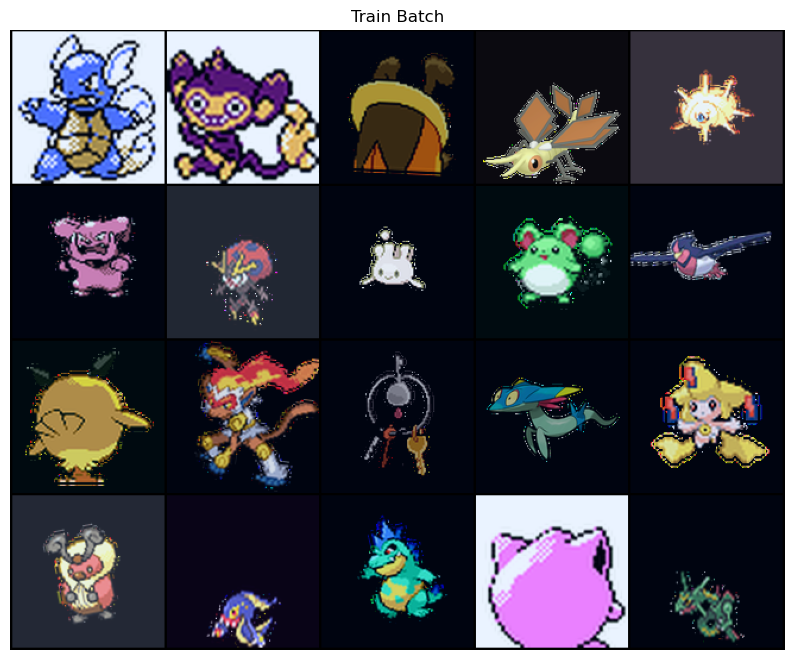

In [6]:
#Define datasets and loaders and show examples from train and validation batches
%matplotlib inline 
def show_batch(dataloader, title, num_images=20):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    print(f"{title} Batch - Labels: {labels.tolist()}")
    print(f"{title} Batch - Image Tensor Shape: {images.shape}")
    grid = vutils.make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

train_image_folder = ImageFolder(train_dir)
test_image_folder = ImageFolder(test_dir)

train_dataset = AlbumentationsDataset(train_image_folder, transform=transform_train)
train_dataset_vit = AlbumentationsDataset(train_image_folder, transform=transform_train_vit)
test_dataset = AlbumentationsDataset(test_image_folder, transform=transform_val_test)
test_dataset_vit = AlbumentationsDataset(test_image_folder, transform=transform_val_test_vit)

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
train_loader_vit = DataLoader(train_dataset_vit, batch_size=250, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=250, shuffle=False)

print("Class names:", train_image_folder.classes)

show_batch(train_loader, "Train Batch")


In [7]:
num_classes = len(train_dataset.classes)
def create_rexnet_model():
    # Create and return a new RexNet model
    model = create_model('rexnet_150', pretrained=True, num_classes=num_classes)
    return model.to(device)

def create_vit_model():
    # Create and return a new ViT model
    VITweights = Tmodels.ViT_B_16_Weights.DEFAULT
    model = Tmodels.vit_b_16(weights=VITweights)
    # Freeze all layers except the classification head
    for param in model.parameters():
        param.requires_grad = False
    # Replace the classification head
    model.heads = torch.nn.Linear(in_features=768, out_features=num_classes)
    return model.to(device)

In [8]:
%matplotlib inline 
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Multiply by batch size to sum the loss over the epoch
            running_train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation step
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step()

    # Plot training and validation accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
    ax1.plot(range(1, epochs + 1), val_accuracies, marker='x', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(range(1, epochs + 1))
    ax1.legend()
    ax1.grid()

    ax2.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
    ax2.plot(range(1, epochs + 1), val_losses, marker='x', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_xticks(range(1, epochs + 1))
    ax2.legend()
    ax2.grid()

    plt.show()


In [9]:
def k_fold_train_model(model_fn, dataset, n_splits=5, epochs=10, batch_size=250):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_val_accuracies = []
    fold_val_losses = []
    fold = 1

    for train_idx, val_idx in kfold.split(dataset):
        print(f"\nStarting fold {fold}/{n_splits}")
        
        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Initialize a new model instance for this fold
        model = model_fn()
        
        # Define criterion, optimizer, and scheduler for this fold
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        
        # Train the model on the current fold
        train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs)
        
        # Evaluate on the validation subset
        model.eval()
        running_val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        
        print(f"Fold {fold} Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        fold_val_losses.append(avg_val_loss)
        fold_val_accuracies.append(val_accuracy)
        fold += 1

    print(f"\nAverage Validation Accuracy over {n_splits} folds: {np.mean(fold_val_accuracies):.4f}")
    print(f"Average Validation Loss over {n_splits} folds: {np.mean(fold_val_losses):.4f}")
    return fold_val_accuracies, fold_val_losses

K‑fold Cross Validation for RexNet:

Starting fold 1/5
Epoch 1/10, Train Loss: 5.1642, Train Accuracy: 0.1821, Validation Loss: 2.6545, Validation Accuracy: 0.5195
Epoch 2/10, Train Loss: 0.9181, Train Accuracy: 0.8106, Validation Loss: 0.5950, Validation Accuracy: 0.8724
Epoch 3/10, Train Loss: 0.1437, Train Accuracy: 0.9597, Validation Loss: 0.3243, Validation Accuracy: 0.9254
Epoch 4/10, Train Loss: 0.0415, Train Accuracy: 0.9796, Validation Loss: 0.2355, Validation Accuracy: 0.9460
Epoch 5/10, Train Loss: 0.0211, Train Accuracy: 0.9838, Validation Loss: 0.2110, Validation Accuracy: 0.9503
Epoch 6/10, Train Loss: 0.0157, Train Accuracy: 0.9849, Validation Loss: 0.1978, Validation Accuracy: 0.9575
Epoch 7/10, Train Loss: 0.0134, Train Accuracy: 0.9849, Validation Loss: 0.1909, Validation Accuracy: 0.9575
Epoch 8/10, Train Loss: 0.0140, Train Accuracy: 0.9845, Validation Loss: 0.1963, Validation Accuracy: 0.9548
Epoch 9/10, Train Loss: 0.0126, Train Accuracy: 0.9850, Validation Loss: 

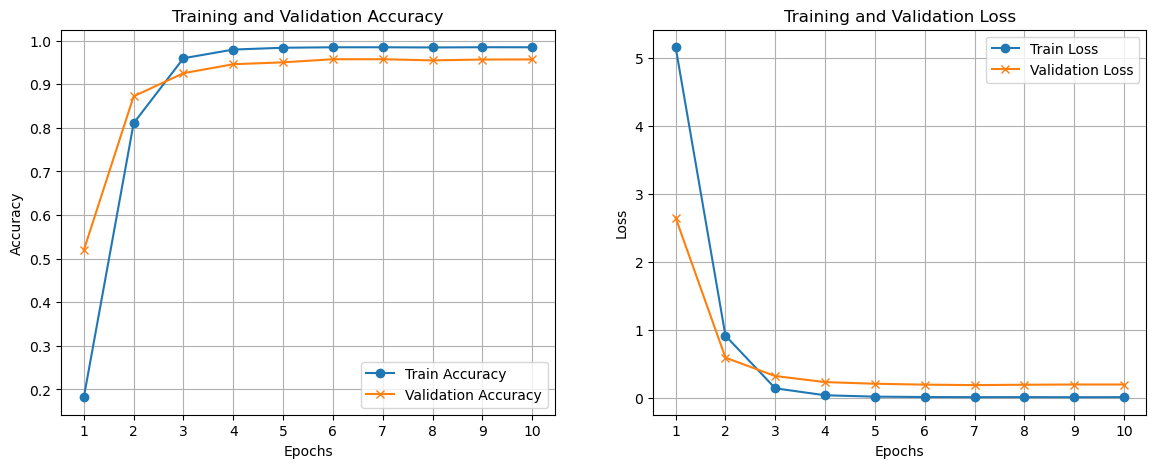

Fold 1 Validation Loss: 0.1961, Validation Accuracy: 0.9529

Starting fold 2/5
Epoch 1/10, Train Loss: 5.1876, Train Accuracy: 0.1852, Validation Loss: 2.6605, Validation Accuracy: 0.5103
Epoch 2/10, Train Loss: 0.9405, Train Accuracy: 0.8047, Validation Loss: 0.6338, Validation Accuracy: 0.8678
Epoch 3/10, Train Loss: 0.1485, Train Accuracy: 0.9570, Validation Loss: 0.3216, Validation Accuracy: 0.9314
Epoch 4/10, Train Loss: 0.0380, Train Accuracy: 0.9805, Validation Loss: 0.2415, Validation Accuracy: 0.9493
Epoch 5/10, Train Loss: 0.0212, Train Accuracy: 0.9834, Validation Loss: 0.2227, Validation Accuracy: 0.9532
Epoch 6/10, Train Loss: 0.0150, Train Accuracy: 0.9849, Validation Loss: 0.2130, Validation Accuracy: 0.9534
Epoch 7/10, Train Loss: 0.0129, Train Accuracy: 0.9846, Validation Loss: 0.2102, Validation Accuracy: 0.9529
Epoch 8/10, Train Loss: 0.0132, Train Accuracy: 0.9849, Validation Loss: 0.2134, Validation Accuracy: 0.9524
Epoch 9/10, Train Loss: 0.0122, Train Accuracy: 0

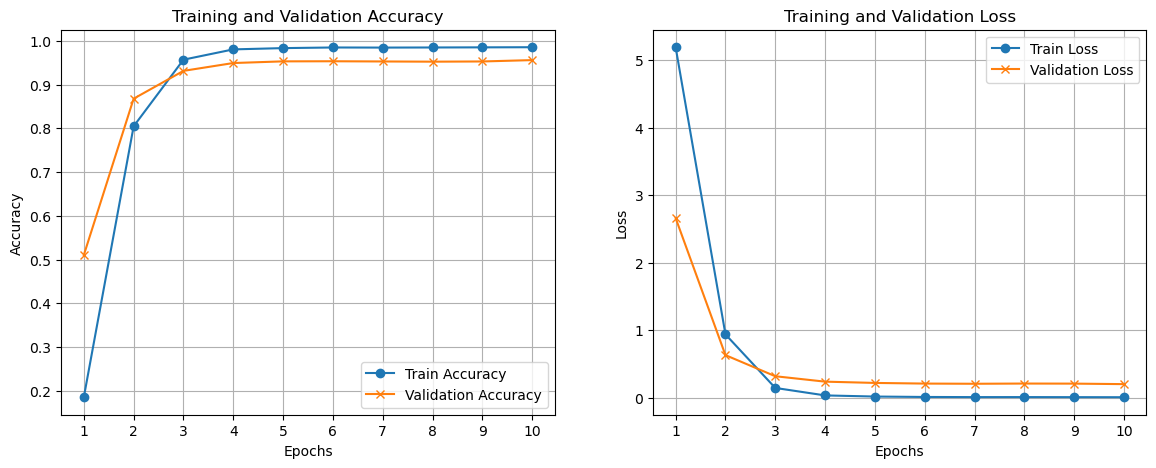

Fold 2 Validation Loss: 0.2121, Validation Accuracy: 0.9529

Starting fold 3/5
Epoch 1/10, Train Loss: 5.0450, Train Accuracy: 0.2030, Validation Loss: 2.4229, Validation Accuracy: 0.5366
Epoch 2/10, Train Loss: 0.8436, Train Accuracy: 0.8226, Validation Loss: 0.4750, Validation Accuracy: 0.8982
Epoch 3/10, Train Loss: 0.1325, Train Accuracy: 0.9585, Validation Loss: 0.2811, Validation Accuracy: 0.9379
Epoch 4/10, Train Loss: 0.0410, Train Accuracy: 0.9798, Validation Loss: 0.1907, Validation Accuracy: 0.9591
Epoch 5/10, Train Loss: 0.0205, Train Accuracy: 0.9839, Validation Loss: 0.1772, Validation Accuracy: 0.9589
Epoch 6/10, Train Loss: 0.0143, Train Accuracy: 0.9852, Validation Loss: 0.1695, Validation Accuracy: 0.9622
Epoch 7/10, Train Loss: 0.0137, Train Accuracy: 0.9848, Validation Loss: 0.1654, Validation Accuracy: 0.9610
Epoch 8/10, Train Loss: 0.0120, Train Accuracy: 0.9852, Validation Loss: 0.1676, Validation Accuracy: 0.9598
Epoch 9/10, Train Loss: 0.0110, Train Accuracy: 0

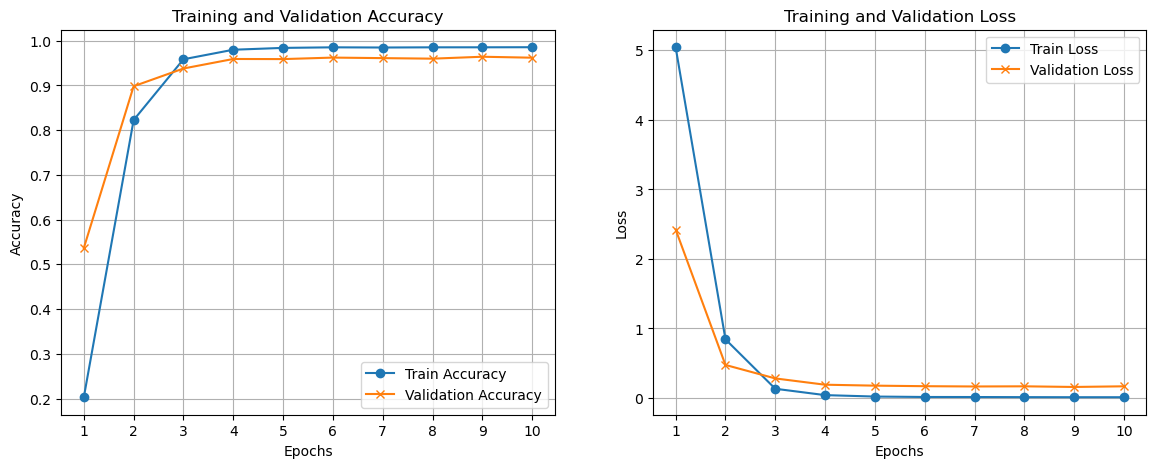

Fold 3 Validation Loss: 0.1681, Validation Accuracy: 0.9627

Starting fold 4/5
Epoch 1/10, Train Loss: 5.1167, Train Accuracy: 0.1907, Validation Loss: 2.5073, Validation Accuracy: 0.5571
Epoch 2/10, Train Loss: 0.8713, Train Accuracy: 0.8160, Validation Loss: 0.5736, Validation Accuracy: 0.8793
Epoch 3/10, Train Loss: 0.1292, Train Accuracy: 0.9606, Validation Loss: 0.3316, Validation Accuracy: 0.9285
Epoch 4/10, Train Loss: 0.0372, Train Accuracy: 0.9804, Validation Loss: 0.2397, Validation Accuracy: 0.9450
Epoch 5/10, Train Loss: 0.0205, Train Accuracy: 0.9842, Validation Loss: 0.2209, Validation Accuracy: 0.9477
Epoch 6/10, Train Loss: 0.0145, Train Accuracy: 0.9846, Validation Loss: 0.2094, Validation Accuracy: 0.9517
Epoch 7/10, Train Loss: 0.0124, Train Accuracy: 0.9848, Validation Loss: 0.2121, Validation Accuracy: 0.9510
Epoch 8/10, Train Loss: 0.0117, Train Accuracy: 0.9848, Validation Loss: 0.2104, Validation Accuracy: 0.9548
Epoch 9/10, Train Loss: 0.0116, Train Accuracy: 0

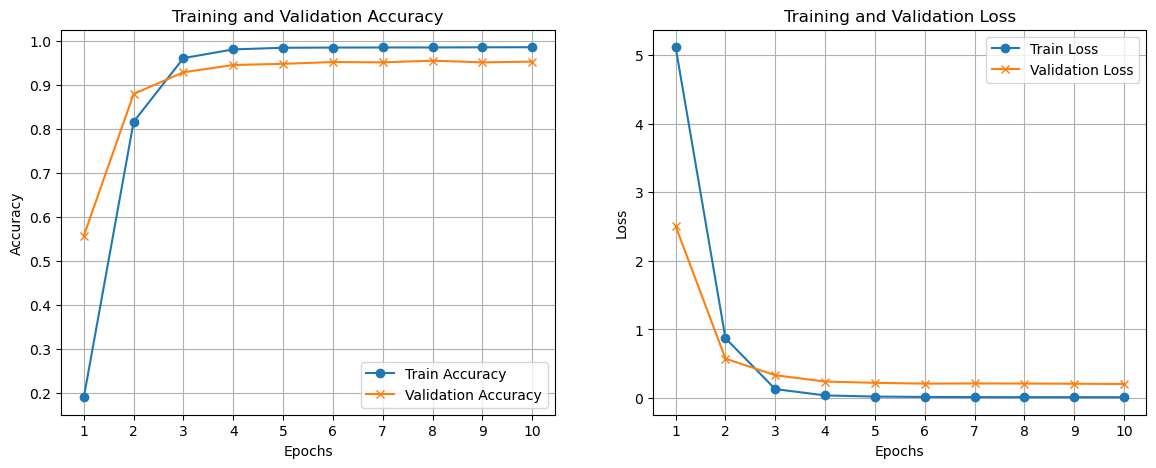

Fold 4 Validation Loss: 0.2097, Validation Accuracy: 0.9522

Starting fold 5/5
Epoch 1/10, Train Loss: 5.1498, Train Accuracy: 0.1873, Validation Loss: 2.5181, Validation Accuracy: 0.5473
Epoch 2/10, Train Loss: 0.8924, Train Accuracy: 0.8099, Validation Loss: 0.5995, Validation Accuracy: 0.8690
Epoch 3/10, Train Loss: 0.1425, Train Accuracy: 0.9578, Validation Loss: 0.3052, Validation Accuracy: 0.9295
Epoch 4/10, Train Loss: 0.0419, Train Accuracy: 0.9800, Validation Loss: 0.2135, Validation Accuracy: 0.9520
Epoch 5/10, Train Loss: 0.0212, Train Accuracy: 0.9840, Validation Loss: 0.1903, Validation Accuracy: 0.9572
Epoch 6/10, Train Loss: 0.0159, Train Accuracy: 0.9847, Validation Loss: 0.1870, Validation Accuracy: 0.9565
Epoch 7/10, Train Loss: 0.0129, Train Accuracy: 0.9848, Validation Loss: 0.1849, Validation Accuracy: 0.9575
Epoch 8/10, Train Loss: 0.0113, Train Accuracy: 0.9853, Validation Loss: 0.1823, Validation Accuracy: 0.9582
Epoch 9/10, Train Loss: 0.0128, Train Accuracy: 0

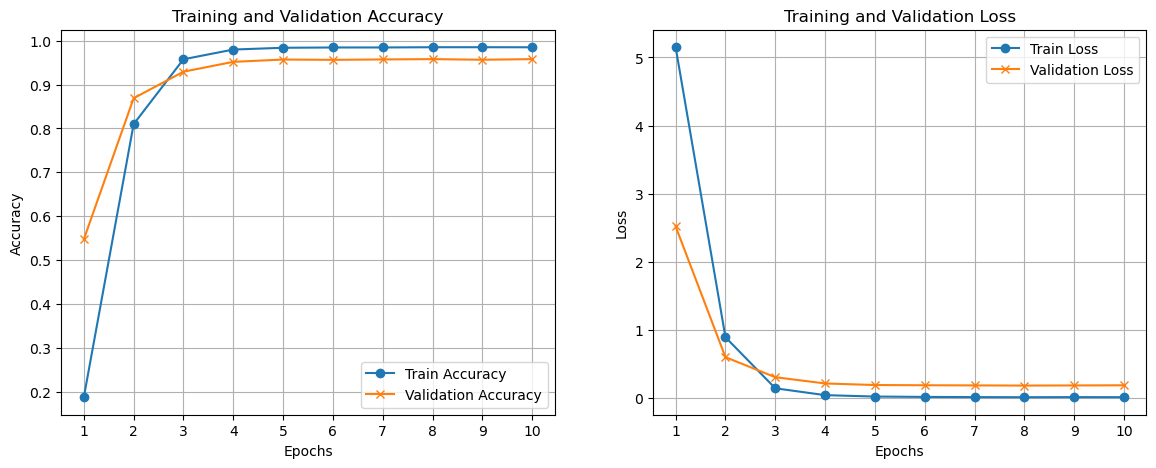

Fold 5 Validation Loss: 0.1908, Validation Accuracy: 0.9567

Average Validation Accuracy over 5 folds: 0.9555
Average Validation Loss over 5 folds: 0.1953


In [10]:
# Run k-fold cross validation for RexNet (using train_dataset with 128x128 transforms)
print("K‑fold Cross Validation for RexNet:")
rexnet_fold_accuracies, rexnet_fold_losses = k_fold_train_model(create_rexnet_model, train_dataset, n_splits=5, epochs=10, batch_size=250)


K‑fold Cross Validation for ViT:

Starting fold 1/5
Epoch 1/9, Train Loss: 5.5722, Train Accuracy: 0.2056, Validation Loss: 4.3086, Validation Accuracy: 0.4425
Epoch 2/9, Train Loss: 3.0254, Train Accuracy: 0.6552, Validation Loss: 2.7322, Validation Accuracy: 0.6593
Epoch 3/9, Train Loss: 1.7287, Train Accuracy: 0.8188, Validation Loss: 1.9222, Validation Accuracy: 0.7622
Epoch 4/9, Train Loss: 1.2115, Train Accuracy: 0.8920, Validation Loss: 1.8366, Validation Accuracy: 0.7861
Epoch 5/9, Train Loss: 1.1465, Train Accuracy: 0.9009, Validation Loss: 1.7813, Validation Accuracy: 0.7888
Epoch 6/9, Train Loss: 1.0952, Train Accuracy: 0.9075, Validation Loss: 1.7269, Validation Accuracy: 0.7912
Epoch 7/9, Train Loss: 1.0529, Train Accuracy: 0.9113, Validation Loss: 1.7189, Validation Accuracy: 0.7969
Epoch 8/9, Train Loss: 1.0518, Train Accuracy: 0.9079, Validation Loss: 1.7217, Validation Accuracy: 0.7928
Epoch 9/9, Train Loss: 1.0434, Train Accuracy: 0.9139, Validation Loss: 1.7083, Val

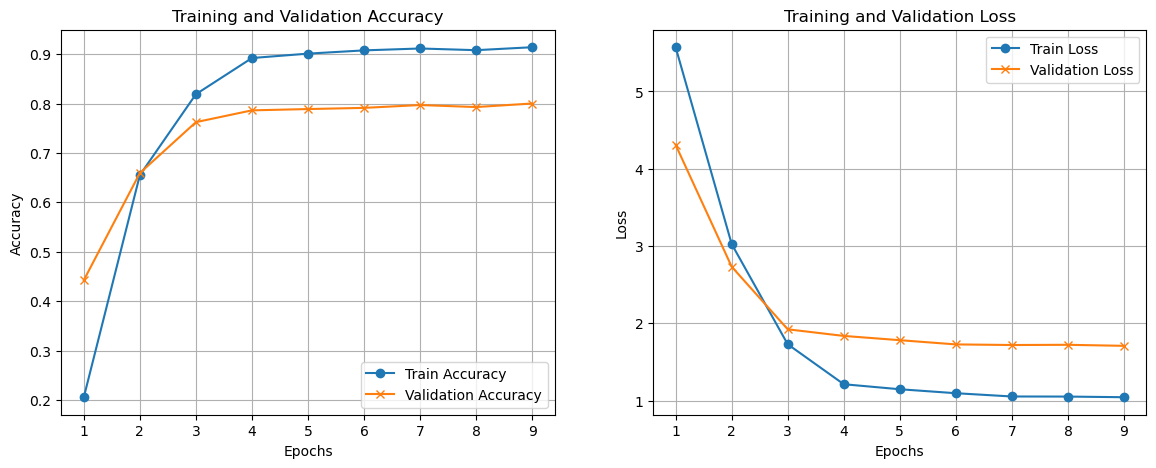

Fold 1 Validation Loss: 1.7179, Validation Accuracy: 0.7912

Starting fold 2/5
Epoch 1/9, Train Loss: 5.5690, Train Accuracy: 0.2061, Validation Loss: 4.3141, Validation Accuracy: 0.4395
Epoch 2/9, Train Loss: 3.0418, Train Accuracy: 0.6486, Validation Loss: 2.6980, Validation Accuracy: 0.6663
Epoch 3/9, Train Loss: 1.7428, Train Accuracy: 0.8166, Validation Loss: 1.8798, Validation Accuracy: 0.7665
Epoch 4/9, Train Loss: 1.2185, Train Accuracy: 0.8859, Validation Loss: 1.8119, Validation Accuracy: 0.7849
Epoch 5/9, Train Loss: 1.1599, Train Accuracy: 0.8988, Validation Loss: 1.7464, Validation Accuracy: 0.7983
Epoch 6/9, Train Loss: 1.1036, Train Accuracy: 0.9073, Validation Loss: 1.6994, Validation Accuracy: 0.8004
Epoch 7/9, Train Loss: 1.0590, Train Accuracy: 0.9121, Validation Loss: 1.6958, Validation Accuracy: 0.8019
Epoch 8/9, Train Loss: 1.0578, Train Accuracy: 0.9128, Validation Loss: 1.6817, Validation Accuracy: 0.8066
Epoch 9/9, Train Loss: 1.0536, Train Accuracy: 0.9108, Va

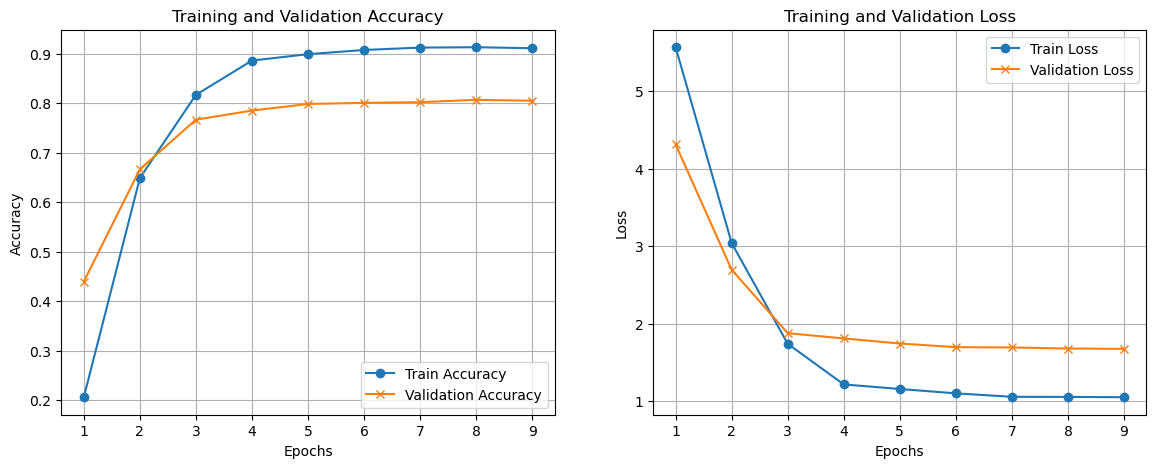

Fold 2 Validation Loss: 1.6784, Validation Accuracy: 0.8083

Starting fold 3/5
Epoch 1/9, Train Loss: 5.5846, Train Accuracy: 0.2030, Validation Loss: 4.3114, Validation Accuracy: 0.4422
Epoch 2/9, Train Loss: 3.0486, Train Accuracy: 0.6484, Validation Loss: 2.6912, Validation Accuracy: 0.6616
Epoch 3/9, Train Loss: 1.7446, Train Accuracy: 0.8203, Validation Loss: 1.8688, Validation Accuracy: 0.7641
Epoch 4/9, Train Loss: 1.2248, Train Accuracy: 0.8861, Validation Loss: 1.7897, Validation Accuracy: 0.7854
Epoch 5/9, Train Loss: 1.1597, Train Accuracy: 0.8965, Validation Loss: 1.7241, Validation Accuracy: 0.8033
Epoch 6/9, Train Loss: 1.1062, Train Accuracy: 0.9042, Validation Loss: 1.6754, Validation Accuracy: 0.7995
Epoch 7/9, Train Loss: 1.0729, Train Accuracy: 0.9090, Validation Loss: 1.6814, Validation Accuracy: 0.7985
Epoch 8/9, Train Loss: 1.0604, Train Accuracy: 0.9109, Validation Loss: 1.6760, Validation Accuracy: 0.7978
Epoch 9/9, Train Loss: 1.0594, Train Accuracy: 0.9090, Va

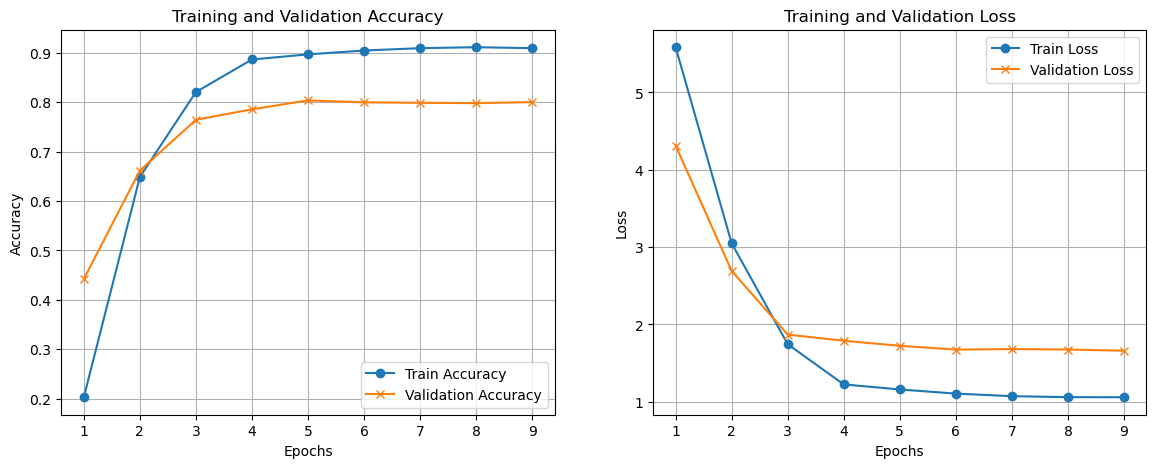

Fold 3 Validation Loss: 1.6548, Validation Accuracy: 0.8028

Starting fold 4/5
Epoch 1/9, Train Loss: 5.5698, Train Accuracy: 0.2069, Validation Loss: 4.3265, Validation Accuracy: 0.4462
Epoch 2/9, Train Loss: 3.0216, Train Accuracy: 0.6526, Validation Loss: 2.7368, Validation Accuracy: 0.6675
Epoch 3/9, Train Loss: 1.7308, Train Accuracy: 0.8196, Validation Loss: 1.9149, Validation Accuracy: 0.7593
Epoch 4/9, Train Loss: 1.2114, Train Accuracy: 0.8877, Validation Loss: 1.8406, Validation Accuracy: 0.7768
Epoch 5/9, Train Loss: 1.1461, Train Accuracy: 0.9003, Validation Loss: 1.7936, Validation Accuracy: 0.7818
Epoch 6/9, Train Loss: 1.1015, Train Accuracy: 0.9034, Validation Loss: 1.7290, Validation Accuracy: 0.7911
Epoch 7/9, Train Loss: 1.0624, Train Accuracy: 0.9101, Validation Loss: 1.7223, Validation Accuracy: 0.7957
Epoch 8/9, Train Loss: 1.0553, Train Accuracy: 0.9098, Validation Loss: 1.7184, Validation Accuracy: 0.7978
Epoch 9/9, Train Loss: 1.0497, Train Accuracy: 0.9106, Va

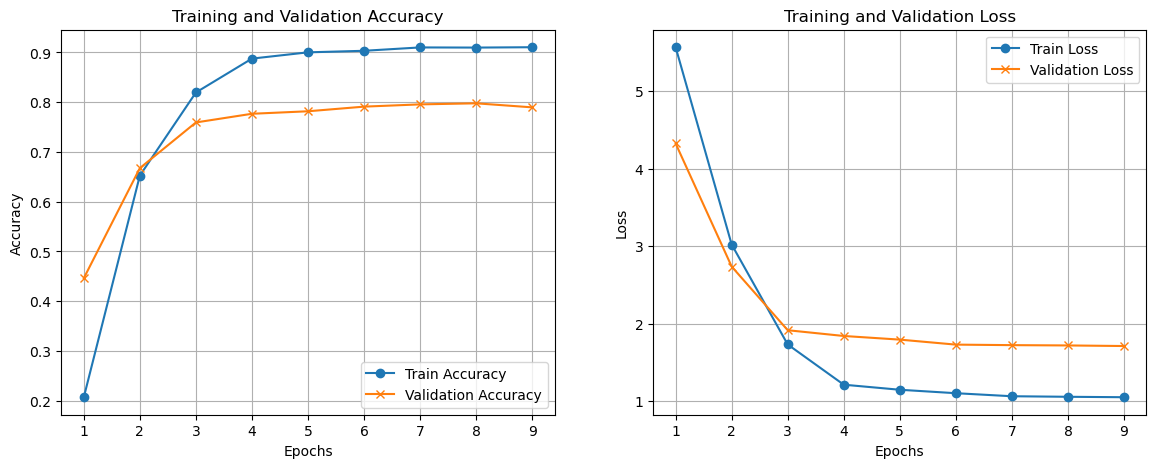

Fold 4 Validation Loss: 1.7077, Validation Accuracy: 0.7930

Starting fold 5/5
Epoch 1/9, Train Loss: 5.5750, Train Accuracy: 0.2023, Validation Loss: 4.2800, Validation Accuracy: 0.4591
Epoch 2/9, Train Loss: 3.0298, Train Accuracy: 0.6524, Validation Loss: 2.6975, Validation Accuracy: 0.6656
Epoch 3/9, Train Loss: 1.7321, Train Accuracy: 0.8194, Validation Loss: 1.8990, Validation Accuracy: 0.7627
Epoch 4/9, Train Loss: 1.2191, Train Accuracy: 0.8867, Validation Loss: 1.8136, Validation Accuracy: 0.7866
Epoch 5/9, Train Loss: 1.1524, Train Accuracy: 0.8977, Validation Loss: 1.7583, Validation Accuracy: 0.7940
Epoch 6/9, Train Loss: 1.1008, Train Accuracy: 0.9089, Validation Loss: 1.6999, Validation Accuracy: 0.8019
Epoch 7/9, Train Loss: 1.0587, Train Accuracy: 0.9091, Validation Loss: 1.7101, Validation Accuracy: 0.8031
Epoch 8/9, Train Loss: 1.0595, Train Accuracy: 0.9119, Validation Loss: 1.6903, Validation Accuracy: 0.7990
Epoch 9/9, Train Loss: 1.0477, Train Accuracy: 0.9126, Va

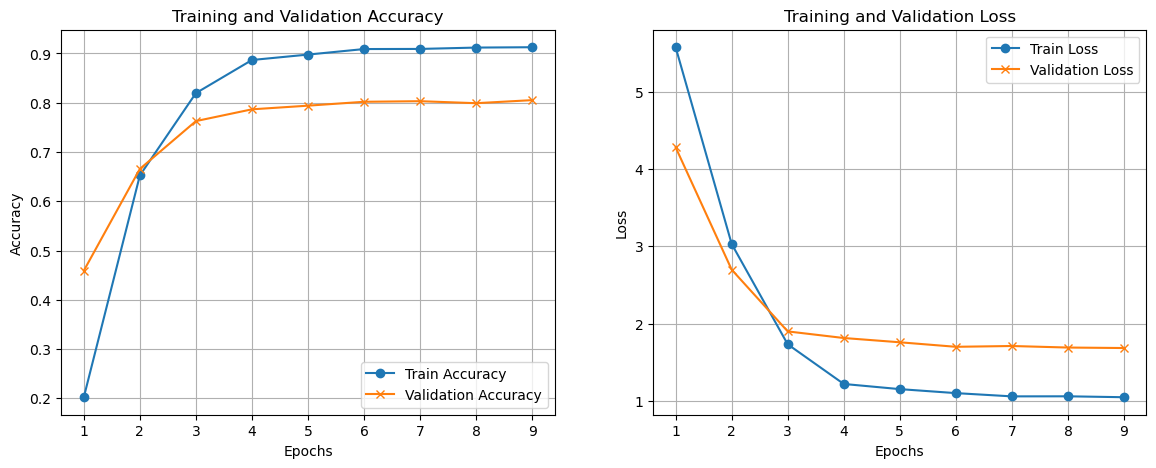

Fold 5 Validation Loss: 1.6932, Validation Accuracy: 0.8021

Average Validation Accuracy over 5 folds: 0.7995
Average Validation Loss over 5 folds: 1.6904


In [11]:
# Run k-fold cross validation for ViT (using train_dataset_vit with 224x224 transforms)
print("\nK‑fold Cross Validation for ViT:")
vit_fold_accuracies, vit_fold_losses = k_fold_train_model(create_vit_model, train_dataset_vit, n_splits=5, epochs=9, batch_size=250)

In [12]:
#Evaluation on Test
def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    all_preds = torch.zeros(len(test_loader.dataset), dtype=torch.long).to(device) 
    all_labels = torch.zeros(len(test_loader.dataset), dtype=torch.long).to(device) 
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            
            start_index = batch_idx * test_loader.batch_size
            end_index = start_index + labels.size(0)
            all_preds[start_index:end_index] = preds
            all_labels[start_index:end_index] = labels
            
            test_correct += (preds == labels).sum().item()

    test_acc = test_correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    print("Classification Report:")
    print(classification_report(all_labels.cpu(), all_preds.cpu(), zero_division=0))

    cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    plt.figure(figsize=(200, 180))  # Adjust figure size as needed
    sns.set(font_scale=0.5)  # Adjust font scale for better readability
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/10, Train Loss: 4.4932, Train Accuracy: 0.2857, Validation Loss: 0.9909, Validation Accuracy: 0.8011
Epoch 2/10, Train Loss: 0.4992, Train Accuracy: 0.8947, Validation Loss: 0.1008, Validation Accuracy: 0.9818
Epoch 3/10, Train Loss: 0.0852, Train Accuracy: 0.9828, Validation Loss: 0.0327, Validation Accuracy: 0.9945
Epoch 4/10, Train Loss: 0.0271, Train Accuracy: 0.9957, Validation Loss: 0.0092, Validation Accuracy: 0.9990
Epoch 5/10, Train Loss: 0.0143, Train Accuracy: 0.9982, Validation Loss: 0.0059, Validation Accuracy: 0.9995
Epoch 6/10, Train Loss: 0.0112, Train Accuracy: 0.9989, Validation Loss: 0.0046, Validation Accuracy: 0.9997
Epoch 7/10, Train Loss: 0.0093, Train Accuracy: 0.9992, Validation Loss: 0.0044, Validation Accuracy: 0.9998
Epoch 8/10, Train Loss: 0.0093, Train Accuracy: 0.9990, Validation Loss: 0.0041, Validation Accuracy: 0.9998
Epoch 9/10, Train Loss: 0.0076, Train Accuracy: 0.9996, Validation Loss: 0.0040, Validation Accuracy: 0.9998
Epoch 10/10, Train 

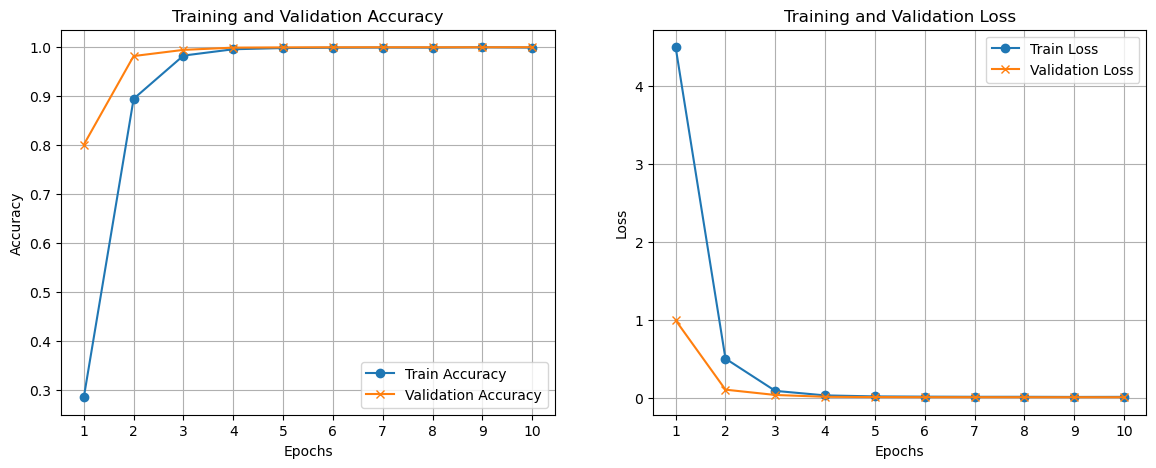

Test Accuracy: 98.24%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.50      0.67         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         4
          16       1.00      1.00   

In [13]:
# Retrain final RexNet model on the entire training set
final_rexnet = create_rexnet_model()
criterion_final = torch.nn.CrossEntropyLoss()
optimizer_final = torch.optim.Adam(final_rexnet.parameters(), lr=0.001)
scheduler_final = torch.optim.lr_scheduler.StepLR(optimizer_final, step_size=3, gamma=0.1)

# Create a DataLoader for the entire training dataset
final_train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)

# Train final model validation on train as entire dataset is too shallow for regular validation
train_model(final_rexnet, criterion_final, optimizer_final, scheduler_final, final_train_loader, val_loader=final_train_loader, epochs=10)
torch.save(final_rexnet.state_dict(),"Final_CNNpokemon.pt")

# Evaluate final model on test set
evaluate_model(final_rexnet, test_loader)

model = final_rexnet

In [16]:
# ----- Final ViT Model Training & Evaluation -----

# Create a fresh final ViT model using your defined function
final_vit = create_vit_model()

# Define loss, optimizer, and learning rate scheduler for the final training
criterion_final_vit = torch.nn.CrossEntropyLoss()
optimizer_final_vit = torch.optim.Adam(final_vit.parameters(), lr=0.001)
scheduler_final_vit = torch.optim.lr_scheduler.StepLR(optimizer_final_vit, step_size=3, gamma=0.1)

# Create a DataLoader for the entire training dataset for ViT (with 224x224 transforms)
final_train_loader_vit = DataLoader(train_dataset_vit, batch_size=250, shuffle=True)

# Train the final ViT model using your updated train_model function validation on train as entire dataset is too shallow for regular validation
train_model(final_vit, criterion_final_vit, optimizer_final_vit, scheduler_final_vit, final_train_loader_vit, val_loader_vit=final_train_loader_vit, epochs=9)

# Save the final ViT model weights
torch.save(final_vit.state_dict(), "Final_VITpokemon.pt")

# Evaluate the final ViT model on the test dataset
evaluate_model(final_vit, test_loader_vit)

modelVIT = final_vit

TypeError: train_model() got an unexpected keyword argument 'val_loader_vit'

In [ ]:
#Single Pokémon Classification Widget (No YOLO Detection) with Clickable URL

def classify_pokemon(image):
    """
    Given an image containing a single Pokemon, predicts its class using Rexnet and ViT ensamble, 
    and returns an annotaded image along with a url
    to the predicted Pokemon's Bulbapedia page (Pokemon wiki).
    """
    try:
        #Ensure the input is a NumPy array
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        image=np.asarray(remove(Image.fromarray(image)))
        if image.shape[2] == 4:
                image = image[:, :, :3]
        #Prepare inputs for RexNet and VIT using the appropriate transforms
        #For RexNet (input size 128)
        transformed_rex = transform_val_test(image=image)
        input_tensor_rex = transformed_rex["image"].unsqueeze(0).to(device)
        
        #For ViT (input size 224)
        transformed_vit = transform_val_test_vit(image=image)
        input_tensor_vit = transformed_vit["image"].unsqueeze(0).to(device)
        
        #Set to evaluation mode
        model.eval()
        modelVIT.eval()
        with torch.no_grad():
            output_rex = model(input_tensor_rex)
            output_vit = modelVIT(input_tensor_vit)
            
            softmax_rex = torch.softmax(output_rex, dim=1)
            softmax_vit = torch.softmax(output_vit, dim=1)
            
            #Ensemble predictions with equal weighting
            ensemble_weight = 0.5
            ensemble_softmax = ensemble_weight * softmax_rex + (1 - ensemble_weight) * softmax_vit
            pred_idx = ensemble_softmax.argmax(dim=1).item()
            ensemble_conf = ensemble_softmax[0, pred_idx].item()
        
        #Extract individual model confidences and class name
        rexnet_conf = torch.max(softmax_rex).item()
        vit_conf = torch.max(softmax_vit).item()
        class_name = train_image_folder.classes[pred_idx]
        
        #Create clickable URL for Bulbapedia.
        base_url = "http://bulbapedia.bulbagarden.net/wiki/"
        url = f"{base_url}{class_name}_(Pokémon)"
        link_html = f'<a href="{url}" target="_blank">Click here for more info on {class_name}</a>'
        
        #Annotate the image with the prediction details
        annotated_image = image.copy()
        annotated_image_cv = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
        label_text = f"{class_name}: Ens {ensemble_conf*100:.1f}% | RexNet {rexnet_conf*100:.1f}% | ViT {vit_conf*100:.1f}%"
        cv2.putText(annotated_image_cv, label_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        annotated_image_cv = cv2.cvtColor(annotated_image_cv, cv2.COLOR_BGR2RGB)
        annotated_pil = PILImage.fromarray(annotated_image_cv)
        
        #Prediction details and the clickable link in HTML
        details_html = f"""
        <p>{label_text}</p>
        <p>{link_html}</p>
        """
        return annotated_pil, details_html

    except Exception as e:
        print("Error in classify_pokemon:", e)
        error_img = np.zeros((256, 256, 3), dtype=np.uint8)
        cv2.putText(error_img, "Error occurred", (10, 128),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return PILImage.fromarray(error_img), "<p>Error occurred.</p>"

In [ ]:
def run_yolo(image_bgr, conf_threshold, iou_threshold):
    model_yolo = modelyolo
    width = image_bgr.shape[0]
    height = image_bgr.shape[1]
    results = model_yolo.predict(source=image_bgr, imgsz=(width, height), conf=conf_threshold, iou=iou_threshold)
    if len(results) == 0 or not results[0].boxes:
        return np.empty((0, 4)), np.empty((0,))

    try:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
    except Exception as e:
        print("Error extracting YOLO boxes/confidences:", e)
        boxes = np.array(results[0].boxes.xyxy)
        confs = np.array(results[0].boxes.conf)
    return boxes, confs

def apply_nms(boxes, confs, conf_threshold, nms_threshold=0.4):
    #Apply Non-Maximum Suppression on detected boxes.
    bboxes = []
    for box in boxes:
        x, y, x2, y2 = box
        bboxes.append([int(x), int(y), int(x2 - x), int(y2 - y)])
    indices = cv2.dnn.NMSBoxes(bboxes, confs.tolist(), score_threshold=conf_threshold, nms_threshold=nms_threshold)
    if len(indices) > 0:
        indices = indices.flatten()
        return boxes[indices], confs[indices]
    else:
        return np.empty((0,4)), np.empty((0,))

def tta_detection(image_bgr, conf_threshold,iou_threshold):
    """
    Perform Test-Time Augmentation by running YOLO on the original and 
    horizontally flipped image, then combine the detections.
    """
    boxes_orig, confs_orig = run_yolo(image_bgr, conf_threshold,iou_threshold)
    image_flip = cv2.flip(image_bgr, 1)
    boxes_flip, confs_flip = run_yolo(image_flip, conf_threshold,iou_threshold)
    
    h, w, _ = image_bgr.shape
    if boxes_flip.shape[0] > 0:
        boxes_flip_adjusted = boxes_flip.copy()
        boxes_flip_adjusted[:, 0] = w - boxes_flip[:, 2]
        boxes_flip_adjusted[:, 2] = w - boxes_flip[:, 0]
    else:
        boxes_flip_adjusted = boxes_flip
    
    if boxes_orig.size > 0 and boxes_flip_adjusted.size > 0:
        combined_boxes = np.concatenate([boxes_orig, boxes_flip_adjusted], axis=0)
        combined_confs = np.concatenate([confs_orig, confs_flip], axis=0)
    elif boxes_orig.size > 0:
        combined_boxes = boxes_orig
        combined_confs = confs_orig
    else:
        combined_boxes = boxes_flip_adjusted
        combined_confs = confs_flip
    
    final_boxes, final_confs = apply_nms(combined_boxes, combined_confs, conf_threshold, nms_threshold=0.4)
    return final_boxes, final_confs

def detect_and_classify(image, conf_threshold=0.1,iou_threshold=0.1):
    """
    Detection and classification with TTA.
    Runs YOLO on the original and flipped images, combines the detections with NMS,
    classifies each region, annotates the image, and returns detailed prediction information.
    """
    ensemble_weight = 0.5  #RexNet weight (ViT gets 1 - ensemble_weight)
    margin = 10            #Margin (pixels) to expand bounding boxes

    detected_details = []  #To accumulate detailed prediction info.

    try:
        #Convert image from RGB to BGR for YOLO.
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        boxes, confs = tta_detection(image_bgr, conf_threshold,iou_threshold)
        print(f"Combined detections: {len(boxes)} boxes found.")
        
        if boxes.shape[0] == 0:
            annotated_image = image.copy()
            annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
            cv2.putText(annotated_image, "No Pokémon detected", (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
            return PILImage.fromarray(annotated_image), "No Pokémon detected."
        
        annotated_image = image_bgr.copy()
        predictions_count = 0
        
        for i, box in enumerate(boxes):
            if confs[i] < conf_threshold:
                continue
            predictions_count += 1
            
            x1, y1, x2, y2 = map(int, box[:4])
            h_img, w_img, _ = image_bgr.shape
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(w_img, x2 + margin)
            y2 = min(h_img, y2 + margin)
            
            #Use rmbg to remove background from crop to improve prediction results by converting to PIL using remove and converting back to numpy
            crop = np.asarray(remove(Image.fromarray(image[y1:y2, x1:x2])))
            if crop.shape[2] == 4:
                crop = crop[:, :, :3]
            if crop.size == 0 or crop.shape[0] < 20 or crop.shape[1] < 20:
                print(f"Skipping crop {i} due to small size.")
                continue
            
            try:
                transformed_rex = transform_val_test(image=crop)
                crop_tensor_rex = transformed_rex["image"].unsqueeze(0).to(device)
            except Exception as e:
                print(f"Error in RexNet transform for detection {i}:", e)
                continue
            
            try:
                transformed_vit = transform_val_test_vit(image=crop)
                crop_tensor_vit = transformed_vit["image"].unsqueeze(0).to(device)
            except Exception as e:
                print(f"Error in ViT transform for detection {i}:", e)
                continue
            
            model.eval()
            modelVIT.eval()
            with torch.no_grad():
                output_rex = model(crop_tensor_rex)
                output_vit = modelVIT(crop_tensor_vit)
                softmax_rex = torch.softmax(output_rex, dim=1)
                softmax_vit = torch.softmax(output_vit, dim=1)
                ensemble_softmax = ensemble_weight * softmax_rex + (1 - ensemble_weight) * softmax_vit
                pred_idx = ensemble_softmax.argmax(dim=1).item()
                ensemble_conf = ensemble_softmax[0, pred_idx].item()
            
            rexnet_conf = torch.max(softmax_rex).item()
            vit_conf = torch.max(softmax_vit).item()
            class_name = train_image_folder.classes[pred_idx]
            
            #Append detailed info.
            detected_details.append(
                f"{class_name}: Ensemble: {ensemble_conf*100:.1f}% | RexNet: {rexnet_conf*100:.1f}% | ViT: {vit_conf*100:.1f}%"
            )
            
            label_text = (f"{class_name}\n"
                          f"Ens: {ensemble_conf*100:.1f}%\n"
                          f"RexNet: {rexnet_conf*100:.1f}%\n"
                          f"ViT: {vit_conf*100:.1f}%")
            
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            y_offset = 0
            for line in label_text.split("\n"):
                cv2.putText(annotated_image, line, (x1, y1 - 10 - y_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                y_offset += 20
        
        if predictions_count == 0:
            cv2.putText(annotated_image, "No predictions above threshold", (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            print("No predictions passed the confidence threshold.")
            detected_details = ["No predictions above threshold."]
        
        annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        annotated_image = np.clip(annotated_image, 0, 255).astype(np.uint8)
        annotated_pil = PILImage.fromarray(annotated_image)
        
        details_str = "\n".join(detected_details)
        return annotated_pil, details_str
    
    except Exception as e:
        print("An error occurred:", e)
        error_img = np.zeros((256, 256, 3), dtype=np.uint8)
        cv2.putText(error_img, "Error occurred", (10, 128),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return PILImage.fromarray(error_img), "Error occurred."

In [ ]:
#Using a File Path Instead of Widgets

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to the image here:
image_path_single = "luc.jpg"

# Load the image using PIL and convert to RGB
image = np.array(Image.open(image_path_single).convert("RGB"))

# Single Pokémon Classification (No YOLO Detection)

print("Running single Pokémon classification...")

# Call the classify_pokemon function (defined earlier)
annotated_image_single, details_html = classify_pokemon(image)
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


# Display the annotated image
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image_single)
plt.title("Single Pokémon Classification")
plt.axis('off')
plt.show()

# Print out the classification details (HTML output printed as text)
print("Classification Details:")
print(details_html)

# Enhanced Pokémon Detection & Classification with TTA

print("\nRunning enhanced detection & classification with TTA...")

# Specify the path to your image here:
image_path_multi = "show.png"

# Load the image using PIL and convert to RGB
image = np.array(Image.open(image_path_multi).convert("RGB"))

# Call the detect_and_classify function (defined earlier)
annotated_image_detection, details_str = detect_and_classify(image, conf_threshold=0.5, iou_threshold=0.01)

# Display the annotated image with detections
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image_detection)
plt.title("Enhanced Detection & Classification with TTA")
plt.axis('off')
plt.show()

# Print out the detailed detection results
print("Detection Details:")
print(details_str)
